In [1]:
# Standard library imports
import os
import pickle
import random
from collections import defaultdict, deque
from pathlib import Path

# Third-party library imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, Layer, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Local application imports
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox, ttk

In [2]:
sns.set()

# Define KAN CNN Model

In [3]:
# Custom ReLU with B-spline parameters
class BSplineReLU(Layer):
    def __init__(self, **kwargs):
        super(BSplineReLU, self).__init__(**kwargs)
        self.control_points = self.add_weight(name='control_points', shape=(4,), initializer='ones', trainable=True)

    def call(self, inputs):
        relu_output = tf.nn.relu(inputs)
        spline_output = relu_output * self.control_points[0] + (1 - relu_output) * self.control_points[1]
        return spline_output


class KANConv2D(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(KANConv2D, self).__init__(**kwargs)
        self.conv = Conv2D(filters, kernel_size, padding='same', **kwargs)
        self.b_spline_relu = BSplineReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        return self.b_spline_relu(x)


def residual_block(x, filters, kernel_size):
    shortcut = Conv2D(filters, (1, 1), padding='same')(x)
    x = KANConv2D(filters, kernel_size)(x)
    x = KANConv2D(filters, kernel_size)(x)
    x = Add()([x, shortcut])
    return x


def KANCNN(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = KANConv2D(32, (3, 3))(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 32, (3, 3))
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64, (3, 3))
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 128, (3, 3))
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BSplineReLU()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [4]:
def CNN(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [5]:
def update_plot(fig, axs, epoch, train_losses, val_losses, lrs, weights_stats, control_points_values, model):
    plt.clf()

    # Plot training and validation loss
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    axs[0].plot(range(1, len(lrs) + 1), lrs, label='Learning Rate')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss / Learning Rate')
    axs[0].legend()

    # Plot weight statistics
    if len(weights_stats) > 0:
        for layer_idx in range(len(weights_stats[0])):
            means = [stat[layer_idx].get('mean', 0) for stat in weights_stats]
            stds = [stat[layer_idx].get('std', 0) for stat in weights_stats]
            means_gamma = [stat[layer_idx].get('mean_gamma', 0) for stat in weights_stats]
            stds_gamma = [stat[layer_idx].get('std_gamma', 0) for stat in weights_stats]
            means_beta = [stat[layer_idx].get('mean_beta', 0) for stat in weights_stats]
            stds_beta = [stat[layer_idx].get('std_beta', 0) for stat in weights_stats]
            moving_mean = [stat[layer_idx].get('moving_mean', 0) for stat in weights_stats]
            moving_variance = [stat[layer_idx].get('moving_variance', 0) for stat in weights_stats]

            if 'mean_gamma' in weights_stats[0][layer_idx]:
                axs[1].plot(range(1, len(weights_stats) + 1), means_gamma, label=f'Layer {layer_idx} Gamma Mean')
                axs[1].fill_between(range(1, len(weights_stats) + 1), np.array(means_gamma) - np.array(stds_gamma),
                                    np.array(means_gamma) + np.array(stds_gamma), alpha=0.2)
            elif 'mean_beta' in weights_stats[0][layer_idx]:
                axs[1].plot(range(1, len(weights_stats) + 1), means_beta, label=f'Layer {layer_idx} Beta Mean')
                axs[1].fill_between(range(1, len(weights_stats) + 1), np.array(means_beta) - np.array(stds_beta),
                                    np.array(means_beta) + np.array(stds_beta), alpha=0.2)
            elif 'moving_mean' in weights_stats[0][layer_idx]:
                axs[1].plot(range(1, len(weights_stats) + 1), moving_mean, label=f'Layer {layer_idx} Moving Mean / Variance')
                axs[1].fill_between(range(1, len(weights_stats) + 1), np.array(moving_mean) - np.array(moving_variance),
                                    np.array(moving_mean) + np.array(moving_variance), alpha=0.2)
            elif 'mean' in weights_stats[0][layer_idx]:
                axs[1].plot(range(1, len(weights_stats) + 1), means, label=f'Layer {layer_idx} Mean')
                axs[1].fill_between(range(1, len(weights_stats) + 1), np.array(means) - np.array(stds),
                                    np.array(means) + np.array(stds), alpha=0.2)

    axs[1].set_title('Weights Mean and Std Dev Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Value')
    axs[1].legend()

    # Plot heatmap for the first Conv2D layer's weights
    if len(weights_stats) > 0 and epoch % 5 == 0:  # Plot every 5 epochs
        for layer in model.layers:
            if isinstance(layer, Conv2D):
                weights = layer.get_weights()[0]
                weights_2d = np.mean(weights, axis=(2, 3))
                heatmap_ax = axs[2]
                sns.heatmap(weights_2d, cmap='coolwarm', ax=heatmap_ax, cbar=False)
                heatmap_ax.set_title(f'Heatmap of Weights for {layer.name}')
                heatmap_ax.set_xlabel('Weights')
                heatmap_ax.set_ylabel('Filters')
                break

    # Plot control points
    if len(control_points_values) > 0:
        for idx, control_points in enumerate(control_points_values):
            axs[3].plot(range(1, len(control_points) + 1), control_points, label=f'Control Points {idx}')

    axs[3].set_title('Control Points Over Epochs')
    axs[3].set_xlabel('Epoch')
    axs[3].set_ylabel('Control Points Value')
    axs[3].legend()

    plt.suptitle(f'Epoch {epoch + 1}')
    plt.pause(0.1)
    fig.canvas.draw()

@tf.function
def train_step(model, optimizer, loss_fn, x_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = loss_fn(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


@tf.function
def val_step(model, loss_fn, x_batch, y_batch):
    predictions = model(x_batch, training=False)
    loss = loss_fn(y_batch, predictions)
    return loss


# Custom training loop
def train_model(data_path: str = './data', epochs: int = 100, total_patience: int = 5, use_kan: bool = False):
    # Define the paths
    train_dir = f'{data_path}/train'
    valid_dir = f'{data_path}/valid'
    test_dir = f'{data_path}/test'

    # Create ImageDataGenerator for loading and augmenting images
    train_datagen = ImageDataGenerator(rescale=1. / 255)
    valid_datagen = ImageDataGenerator(rescale=1. / 255)
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        shuffle=True
    )

    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        shuffle=False
    )

    if use_kan:
        model_path = f'./models/{epochs}_KAN_model.h5'
    else:
        model_path = f'./models/{epochs}_model.h5'

    input_shape = (224, 224, 3)
    num_classes = 53  # 53 classes for 53 cards
    model = KANCNN(input_shape, num_classes) if use_kan else CNN(input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    if Path(model_path).exists():
        model.load_weights(model_path)
        return model

    optimizer = Adam()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    train_losses = []
    val_losses = []
    lrs = []
    control_points_values = []
    weights_stats = []

    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    patience = 0
    best_val_loss = float('inf')
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_loss, val_loss = 0, 0
        total_batches = len(train_generator)
        last_printed_percentage = -1
        for idx in range(total_batches):
            x_batch, y_batch = train_generator[idx]
            progress = ((idx + 1) / total_batches) * 100  # Calculate progress as a percentage

            # Check if the current progress is a multiple of 10 and different from the last printed percentage
            if int(progress) % 10 == 0 and int(progress) != last_printed_percentage and progress >= 10:
                print(f"Batch {idx}: {progress:.0f}%")
                last_printed_percentage = int(progress)

            train_loss += train_step(model, optimizer, loss_fn, x_batch, y_batch)

        for idx in range(len(valid_generator)):
            x_batch, y_batch = valid_generator[idx]
            progress = (idx + 1) / total_batches * 100  # Calculate progress as a percentage

            # Check if the current progress is a multiple of 10 and different from the last printed percentage
            if int(progress) % 10 == 0 and int(progress) != last_printed_percentage and progress >= 10:
                print(f"Batch {idx}: {progress:.0f}%")
                last_printed_percentage = int(progress)

            val_loss += val_step(model, loss_fn, x_batch, y_batch)

        # Average the losses over batches
        train_loss /= len(train_generator)
        val_loss /= len(valid_generator)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Learning rate (if you are changing it dynamically)
        lrs.append(optimizer.learning_rate.numpy())

        # Collect control points and weight statistics
        control_points = []
        layer_weights_stats = []
        for layer in model.layers:
            if isinstance(layer, BSplineReLU):
                control_points.append(layer.control_points.numpy())
            elif isinstance(layer, (KANConv2D, Conv2D)):
                weights = layer.get_weights()[0]  # Assuming weights are in index 0
                mean = np.mean(weights)
                std = np.std(weights)
                layer_weights_stats.append({'mean': mean, 'std': std})
            elif isinstance(layer, tf.keras.layers.BatchNormalization):
                gamma, beta = layer.get_weights()[0], layer.get_weights()[1]
                moving_mean = layer.get_weights()[2]
                moving_variance = layer.get_weights()[3]
                mean_gamma = np.mean(gamma)
                std_gamma = np.std(gamma)
                mean_beta = np.mean(beta)
                std_beta = np.std(beta)
                layer_weights_stats.append(
                    {
                        'mean_gamma': mean_gamma, 'std_gamma': std_gamma, 'mean_beta': mean_beta,
                        'std_beta': std_beta, 'moving_mean': moving_mean, 'moving_variance': moving_variance
                    }
                )

        control_points_values.append(control_points)
        weights_stats.append(layer_weights_stats)

        update_plot(fig, axs, epoch, train_losses, val_losses, lrs, weights_stats, control_points_values, model)

        # Update B-spline parameters and control points
        for layer in model.layers:
            if isinstance(layer, KANConv2D) or isinstance(layer, BSplineReLU):
                with tf.GradientTape() as tape:
                    tape.watch([tf.convert_to_tensor(w) for w in layer.trainable_weights])
                    predictions = model(train_generator[0][0])
                    loss = tf.keras.losses.categorical_crossentropy(train_generator[0][1], predictions)

                grads = tape.gradient(loss, layer.trainable_weights)
                for weight, grad in zip(layer.trainable_weights, grads):
                    if isinstance(weight, tf.Variable):
                        weight.assign_sub(grad * 0.01)  # Update step size

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= total_patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    # Evaluate the model
    loss, accuracy = model.evaluate(test_generator)
    print(f'Test accuracy: {accuracy}')

    model.save(model_path)
    return model

In [6]:
model = train_model(epochs=25)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [7]:
class CardCounter:
    high_cards = ('ten', 'jack', 'queen', 'king', 'ace')
    low_cards = ('two', 'three', 'four', 'five', 'six')

    def __init__(self, model, n_decks: int = 8):
        self.model = model
        self.n_decks = n_decks
        self.total_cards = 52 * n_decks
        self._count = 0
        self._remaining_cards = {
            'total': self.total_cards,
            'high': int(round(self.total_cards * 5 / 13)),
            'low': int(round(self.total_cards * 5 / 13)),
            'neutral': int(round(self.total_cards * 3 / 13))
        }

        self.test_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
            './data/test',
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
        )

        self.card_counts = {label: 0 for label in self.test_generator.class_indices.keys()}

    @property
    def count(self):
        return self._count

    @count.setter
    def count(self, count: int):
        self._count = count

    @property
    def remaining_cards(self):
        return self._remaining_cards

    @remaining_cards.setter
    def remaining_cards(self, remaining_cards: int):
        self._remaining_cards = remaining_cards

    def reset_deck(self):
        self.total_cards = 52 * self.n_decks

        self.remaining_cards = {
            'total': self.total_cards,
            'high': int(round(self.total_cards * 5 / 13)),
            'low': int(round(self.total_cards * 5 / 13)),
            'neutral': int(round(self.total_cards * 3 / 13))
        }

        self.count = 0
        self.card_counts = {label: 0 for label in self.test_generator.class_indices.keys()}

    def classify_card(self, image):
        image = tf.image.resize(image, (224, 224))
        image = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = self.model.predict(image)
        class_index = tf.argmax(predictions[0]).numpy()
        class_label = list(self.test_generator.class_indices.keys())[class_index]
        return class_label

    def count_cards(self, images):
        high_cards = 0
        low_cards = 0
        neutral_cards = 0
        card_labels = []
        for image in images:
            card_label = self.classify_card(image=image)
            rank = card_label.split()[0]
            suit = card_label.split()[-1]
            card_labels.append((rank, suit))
            self.card_counts[card_label] += 1

            if card_label.split()[0] in self.high_cards:
                self.count -= 1
                high_cards += 1
            elif card_label.split()[0] in self.low_cards:
                self.count += 1
                low_cards += 1
            else:
                neutral_cards += 1

        # Calculate remaining cards
        self.remaining_cards['total'] -= len(images)
        self.remaining_cards['high'] -= high_cards
        self.remaining_cards['low'] -= low_cards
        self.remaining_cards['neutral'] -= neutral_cards

        prob_high = self.remaining_cards['high'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0
        prob_low = self.remaining_cards['low'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0
        prob_neutral = self.remaining_cards['neutral'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0

        return prob_high, prob_low, prob_neutral, card_labels

In [8]:
image_paths = [r'.\data\test\ace of clubs\1.jpg', r'.\data\test\nine of clubs\1.jpg', 
               r'.\data\test\six of clubs\1.jpg', r'.\data\test\king of hearts\1.jpg']

images = [tf.io.read_file(image_path) for image_path in image_paths]
images = [tf.image.decode_jpeg(image, channels=3) for image in images]

In [9]:
card_counter = CardCounter(model=model)
prob_high, prob_low, prob_neutral, card_labels = card_counter.count_cards(images=images)
print(f'Predicted Cards: {card_labels}')
print(f'Probability of next card being +1 count: {prob_low:.2f}')
print(f'Probability of next card being -1 count: {prob_high:.2f}')
print(f'Probability of next card being 0 count: {prob_neutral:.2f}')

Found 265 images belonging to 53 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Cards: [('nine', 'clubs'), ('nine', 'clubs'), ('five', 'clubs'), ('ace', 'clubs')]
Probability of next card being +1 count: 0.39
Probability of next card being -1 count: 0.39
Probability of next card being 0 count: 0.23


In [10]:
class BlackjackGame:
    def __init__(self, root, bankroll: int, model_path: str, cost: int = 100):
        self.root = root
        self.root.title("Blackjack Game")

        self.suits = ('hearts', 'diamonds', 'clubs', 'spades')
        self.ranks = {
            'two': 2,
            'three': 3,
            'four': 4,
            'five': 5,
            'six': 6,
            'seven': 7,
            'eight': 8,
            'nine': 9,
            'ten': 10,
            'jack': 10,
            'queen': 10,
            'king': 10,
            'ace': 11
        }

        # Load the trained model
        self.model_path = model_path
        self.model = self.load_model()

        # Initialize the card counter
        self.card_counter = CardCounter(model=self.model)
        self.deck = self.create_deck()

        # Initialize game variables
        self.starting_bankroll = bankroll
        self._bankroll = bankroll
        self.cost = cost
        self._current_cost = cost
        self._blackjack_wins = 0
        self._regular_wins = 0
        self._losses = 0
        self._draws = 0
        self._hits = 0
        self._splits = 0
        self._stands = 0
        self._doubles = 0
        self._surrenders = 0
        self._insurance_wins = 0
        self._insurance_losses = 0
        self._insurance_used = False
        self._hand_count = 0
        self._active_hand = 0
        self._dealer_hand = []
        self._card_images = []
        self._player_hands = [[]]
        self._probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
        self._available_rewards = {'Blackjack': int(cost * 1.5), 'Regular': cost, 'Loss': -cost}
        self.game_log = []

        # Create a main container frame to hold player and dealer frames
        self.main_container = tk.Frame(self.root)
        self.main_container.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.player_label = tk.Label(self.main_container, text="Player's Hand")
        self.player_label.pack()

        self.frames_container = tk.Frame(self.main_container)
        self.frames_container.pack()

        self._player_frames = [
            tk.Frame(self.frames_container, padx=25) if i != 0 else tk.Frame(self.frames_container, padx=25,
                                                                             bg='lightblue') for i in
            range(4 * self.card_counter.n_decks)]
        for frame in self._player_frames:
            frame.pack(side=tk.LEFT)

        self.dealer_label = tk.Label(self.main_container, text="Dealer's Hand")
        self.dealer_label.pack()
        self.dealer_frame = tk.Frame(self.main_container)
        self.dealer_frame.pack()
        self._placeholder_frame = None

        self.hit_button = tk.Button(self.main_container, text="Hit", command=self.hit)
        self.hit_button.pack(side=tk.LEFT)
        self.stand_button = tk.Button(self.main_container, text="Stand", command=self.stand)
        self.stand_button.pack(side=tk.LEFT)
        self.split_button = tk.Button(self.main_container, text="Split", command=self.split)  # Add split button
        self.split_button.pack(side=tk.LEFT)
        self.double_button = tk.Button(self.main_container, text="Double", command=self.double)  # Add double button
        self.double_button.pack(side=tk.LEFT)
        self.surrender_button = tk.Button(self.main_container, text="Surrender", command=self.surrender)  # Add surrender button
        self.surrender_button.pack(side=tk.LEFT)
        self.insurance_button = tk.Button(self.main_container, text="Insurance", command=self.insurance)  # Add insurance button
        self.insurance_button.pack(side=tk.LEFT)
        self.reset_button = tk.Button(self.main_container, text="Reset", command=self.reset_game)
        self.reset_button.pack(side=tk.LEFT)

        self.prob_label = tk.Label(self.main_container, text=f"Probabilities - High: {self._probabilities['High'][0]}, Low: {self._probabilities['High'][0]}, Neutral: {self._probabilities['High'][0]}")
        self.prob_label.pack()

        self.game_label = tk.Label(self.main_container, text=f'Game {self.regular_wins + self.blackjack_wins + self.losses + self.draws}: Blackjack Wins - {self.blackjack_wins}, Regular Wins - {self.regular_wins}, Losses - {self.losses}, Draws - {self.draws} -- Cards Left = {self.card_counter.remaining_cards["total"]}')
        self.game_label.pack()

        self.wallet_label = tk.Label(self.main_container, text=f"Bankroll: ${self.bankroll}")
        self.wallet_label.pack()

        # Create the frame for the plots and logs
        self.plot_frame = tk.Frame(self.root)
        self.plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

        # Plot frame should contain both the canvas and the log_frame side by side
        self.fig, self.axs = plt.subplots(2, 2, figsize=(10, 8))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.plot_frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Create a scrollable text widget for logs
        self.log_frame = tk.Frame(self.plot_frame)
        self.log_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)
        self.log_text = tk.Text(self.log_frame, wrap=tk.WORD, state=tk.NORMAL)
        self.log_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.log_scrollbar = ttk.Scrollbar(self.log_frame, command=self.log_text.yview)
        self.log_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.log_text.config(yscrollcommand=self.log_scrollbar.set)

        # Initialize data for plots
        self._returns = []
        self._average_returns = []
        self._remaining_hands = {}

        # Initialize the animation
        self.ani = FuncAnimation(self.fig, self.update_plots, interval=1000)

    @property
    def bankroll(self):
        return self._bankroll

    @bankroll.setter
    def bankroll(self, bankroll):
        self._bankroll = bankroll

    @property
    def current_cost(self):
        return self._current_cost

    @current_cost.setter
    def current_cost(self, current_cost):
        self._current_cost = current_cost

    @property
    def blackjack_wins(self):
        return self._blackjack_wins

    @blackjack_wins.setter
    def blackjack_wins(self, blackjack_wins):
        self._blackjack_wins = blackjack_wins

    @property
    def regular_wins(self):
        return self._regular_wins

    @regular_wins.setter
    def regular_wins(self, regular_wins):
        self._regular_wins = regular_wins

    @property
    def losses(self):
        return self._losses

    @losses.setter
    def losses(self, losses):
        self._losses = losses

    @property
    def draws(self):
        return self._draws

    @draws.setter
    def draws(self, draws):
        self._draws = draws

    @property
    def hits(self):
        return self._hits

    @hits.setter
    def hits(self, hits):
        self._hits = hits

    @property
    def splits(self):
        return self._splits

    @splits.setter
    def splits(self, splits):
        self._splits = splits

    @property
    def stands(self):
        return self._stands

    @stands.setter
    def stands(self, stands):
        self._stands = stands

    @property
    def doubles(self):
        return self._doubles

    @doubles.setter
    def doubles(self, doubles):
        self._doubles = doubles

    @property
    def surrenders(self):
        return self._surrenders

    @surrenders.setter
    def surrenders(self, surrenders):
        self._surrenders = surrenders

    @property
    def insurance_wins(self):
        return self._insurance_wins

    @insurance_wins.setter
    def insurance_wins(self, insurance_wins):
        self._insurance_wins = insurance_wins

    @property
    def insurance_losses(self):
        return self._insurance_losses

    @insurance_losses.setter
    def insurance_losses(self, insurance_losses):
        self._insurance_losses = insurance_losses

    @property
    def insurance_used(self):
        return self._insurance_used

    @insurance_used.setter
    def insurance_used(self, insurance_used):
        self._insurance_used = insurance_used

    @property
    def hand_count(self):
        return self._hand_count

    @hand_count.setter
    def hand_count(self, hand_count):
        self._hand_count = hand_count

    @property
    def active_hand(self):
        return self._active_hand

    @active_hand.setter
    def active_hand(self, active_hand):
        self._active_hand = active_hand

    @property
    def dealer_hand(self):
        return self._dealer_hand

    @dealer_hand.setter
    def dealer_hand(self, dealer_hand):
        self._dealer_hand = dealer_hand

    @property
    def card_images(self):
        return self._card_images

    @card_images.setter
    def card_images(self, card_images):
        self._card_images = card_images

    @property
    def player_hands(self):
        return self._player_hands

    @player_hands.setter
    def player_hands(self, player_hands):
        self._player_hands = player_hands

    @property
    def player_frames(self):
        return self._player_frames

    @player_frames.setter
    def player_frames(self, player_frames):
        self._player_frames = player_frames

    @property
    def probabilities(self):
        return self._probabilities

    @probabilities.setter
    def probabilities(self, probabilities):
        self._probabilities = probabilities

    @property
    def available_rewards(self):
        self._available_rewards = {'Blackjack': int(self.current_cost * 1.5), 'Regular': self.current_cost, 'Loss': -self.current_cost}
        return self._available_rewards

    @available_rewards.setter
    def available_rewards(self, available_rewards):
        self._available_rewards = available_rewards

    @property
    def returns(self):
        return self._returns

    @returns.setter
    def returns(self, returns):
        self._returns = returns

    @property
    def average_returns(self):
        return self._average_returns

    @average_returns.setter
    def average_returns(self, average_returns):
        self._average_returns = average_returns

    @property
    def placeholder_frame(self):
        return self._placeholder_frame

    @placeholder_frame.setter
    def placeholder_frame(self, placeholder_frame):
        self._placeholder_frame = placeholder_frame

    @property
    def remaining_hands(self):
        return self._remaining_hands

    @remaining_hands.setter
    def remaining_hands(self, remaining_hands):
        self._remaining_hands = remaining_hands

    def log_prefix(self, idx: int):
        return f'Hand {self.hand_count}: Active Hand {idx + 1} -'

    def load_model(self, use_kan: bool = False):
        input_shape = (224, 224, 3)
        num_classes = 53  # 53 classes for 53 cards

        model = KANCNN(input_shape, num_classes) if use_kan else CNN(input_shape, num_classes)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.load_weights(self.model_path)  # Load your trained model weights
        return model

    def create_deck(self):
        deck = [(rank, suit) for rank in self.ranks.keys() for suit in self.suits for _ in
                range(self.card_counter.n_decks)]
        random.shuffle(deck)
        return deck

    def display_hand(self, card, is_dealer):
        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'

        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            return

        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
        self.probabilities['High'].append(prob_high)
        self.probabilities['Low'].append(prob_low)
        self.probabilities['Neutral'].append(prob_neutral)

        try:
            img = Image.open(img_path)
            img = img.resize((100, 150), Image.LANCZOS)
            photo = ImageTk.PhotoImage(img)
            self.card_images.append(photo)
            frame = tk.Frame(self.dealer_frame if is_dealer else self.player_frames[self.active_hand])
            frame.pack(side=tk.LEFT)
            label = tk.Label(frame, image=photo)
            label.image = photo
            label.pack()
            frame_text = f'Actual: {card[0]} of {card[1]}\nPredicted: {predicted_cards[0][0]} of {predicted_cards[0][1]}'
            tk.Label(frame, text=frame_text).pack()
        except Exception as e:
            print(f"Failed to load image {img_path}: {e}")

        self.update_probabilities_label()

    def display_back(self):
        img_path = f'./data/card back black.png'

        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            return

        try:
            img = Image.open(img_path)
            img = img.resize((100, 150), Image.LANCZOS)
            photo = ImageTk.PhotoImage(img)
            self.card_images.append(photo)
            self.placeholder_frame = tk.Frame(self.dealer_frame)
            self.placeholder_frame.pack(side=tk.LEFT)
            label = tk.Label(self.placeholder_frame, image=photo)
            label.image = photo
            label.pack()
            tk.Label(self.placeholder_frame, text='').pack()
        except Exception as e:
            print(f"Failed to load image {img_path}: {e}")

    def deal_card(self, hand: list, is_dealer: bool = False, show: bool = True):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            self.probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
            self.card_images = []

        hand.append(card)

        if show:
            self.display_hand(card=card, is_dealer=is_dealer)
        else:
            self.display_back()

    def calculate_hand_value(self, hand):
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += self.ranks[rank]

            if rank == 'ace':
                ace_count += 1

        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1

        return value

    def update_probabilities_label(self):
        self.prob_label.config(text=f'Probabilities - High: {self.probabilities["High"][-1]:.2f}, Low: {self.probabilities["Low"][-1]:.2f}, Neutral: {self.probabilities["Neutral"][-1]:.2f}')

    def update_game_label(self, rewards):
        self.game_label.config(text=f'Game {self.regular_wins + self.blackjack_wins + self.losses + self.draws}: Blackjack Wins - {self.blackjack_wins}, Regular Wins - {self.regular_wins}, Losses - {self.losses}, Draws - {self.draws} -- Cards Left = {self.card_counter.remaining_cards["total"]}')
        self.bankroll += rewards
        self.wallet_label.config(text=f"Bankroll: ${self.bankroll}")

    def update_plots(self, *args):
        win_data = {
            "regular_wins": self.regular_wins,
            "blackjack_wins": self.blackjack_wins,
            "insurance_wins": self.insurance_wins,
            "insurance_losses": self.insurance_losses,
            "losses": self.losses,
            "draws": self.draws,
        }

        prob_data = {
            "high": self.probabilities["High"][-1],
            "low": self.probabilities["Low"][-1],
            "neutral": self.probabilities["Neutral"][-1]
        }

        action_data = {
            "hits": self.hits,
            "stands": self.stands,
            "splits": self.splits,
            "doubles": self.doubles,
            "surrenders": self.surrenders,
        }

        # Clear previous plots
        for ax in self.axs.flat:
            ax.clear()

        # Plot 1: Wins, Losses, Draws
        self.axs[0, 0].bar(win_data.keys(), win_data.values())
        self.axs[0, 0].set_title("Wins, Losses, Draws")
        self.axs[0, 0].set_ylabel("Count")
        self.axs[0, 0].tick_params(axis='x', rotation=45)

        # Plot 2: Probabilities
        self.axs[0, 1].bar(prob_data.keys(), prob_data.values())
        self.axs[0, 1].set_title("Probabilities")
        self.axs[0, 1].set_ylabel("Probability")
        self.axs[0, 1].tick_params(axis='x', rotation=45)

        # Plot 3: Average Returns
        if self.hand_count > 0:
            self.axs[1, 0].plot(range(1, len(self.average_returns) + 1), self.average_returns)

        self.axs[1, 0].set_title("Average Returns per Hand")
        self.axs[1, 0].set_ylabel("Average Return")
        self.axs[1, 0].set_xlabel("Number of Hands")
        self.axs[1, 0].tick_params(axis='x', rotation=45)

        # Plot 4: Hits, Stands, Splits
        self.axs[1, 1].bar(action_data.keys(), action_data.values())
        self.axs[1, 1].set_title("Actions")
        self.axs[1, 1].set_ylabel("Count")
        self.axs[1, 1].tick_params(axis='x', rotation=45)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0.4, hspace=0.8)

        # Refresh the canvas
        self.canvas.draw()

    def log_message(self, message):
        self.game_log.append(message)
        self.log_text.config(state=tk.NORMAL)
        self.log_text.insert(tk.END, message + "\n")
        self.log_text.config(state=tk.NORMAL)
        self.log_text.yview(tk.END)

    def start_game(self):
        self.hand_count += 1
        self.insurance_used = False
        self.deal_card(self.player_hands[0])
        self.deal_card(self.dealer_hand, is_dealer=True)
        self.deal_card(self.player_hands[0])
        self.deal_card(self.dealer_hand, is_dealer=True, show=False)

        self.remaining_hands[0] = self.player_hands[0]

        player_value = self.calculate_hand_value(self.player_hands[0])
        if player_value == 21:
            reward = self.available_rewards["Blackjack"]
            self.blackjack_wins += 1
            self.update_game_label(reward)
            self.returns.append(reward)
            self.average_returns.append(sum(self.returns) / self.hand_count)
            message = f"{self.log_prefix(0)} Blackjack! Player wins ${reward}!"
            self.log_message(message)
            self.reset_hand()

        # Enable the split button if the player has two cards of the same rank
        self.update_split_button_state()
        self.update_surrender_button_state()
        self.update_insurance_button_state()

    def update_split_button_state(self):
        can_split = any(len(hand) == 2 and hand[0][0] == hand[1][0] for hand in self.player_hands)
        self.split_button.config(state=tk.NORMAL if can_split else tk.DISABLED)

    def update_surrender_button_state(self):
        can_surrender = len(self.player_hands) == 1 and len(self.player_hands[0]) == 2
        self.surrender_button.config(state=tk.NORMAL if can_surrender else tk.DISABLED)

    def update_insurance_button_state(self):
        can_surrender = self.dealer_hand[0][0] == 'ace' and not self.insurance_used
        self.insurance_button.config(state=tk.NORMAL if can_surrender else tk.DISABLED)

    def split(self):
        # Check if the active hand can be split
        active_hand = self.player_hands[self.active_hand]
        if len(active_hand) == 2 and active_hand[0][0] == active_hand[1][0]:
            self.splits += 1
            new_hand = [self.player_hands[self.active_hand].pop()]
            self.deal_card(new_hand)
            self.deal_card(self.player_hands[self.active_hand])
            self.player_hands.append(new_hand)
            self.remaining_hands[self.active_hand] = self.player_hands[self.active_hand]
            self.remaining_hands[len(self.player_hands) - 1] = new_hand

        for frame in self.player_frames[1:]:
            frame.pack(side=tk.LEFT, padx=10)

        for idx, hand in enumerate(self.player_hands):
            if self.calculate_hand_value(hand) == 21:
                self.blackjack_wins += 1
                self.update_game_label(self.available_rewards["Blackjack"])
                self.returns.append(self.available_rewards["Blackjack"])
                self.average_returns.append(sum(self.returns) / self.hand_count)
                message = f"{self.log_prefix(idx)} Blackjack! Player wins ${self.available_rewards['Blackjack']}!"
                self.log_message(message)
                if idx in self.remaining_hands:
                    del self.remaining_hands[idx]

        while self.active_hand < len(self.player_hands) and self.active_hand not in self.remaining_hands.keys():
            self.active_hand += 1

        self.highlight_active_hand()
        self.update_hand_display()
        self.update_split_button_state()
        self.update_surrender_button_state()
        self.update_insurance_button_state()

    def highlight_active_hand(self):
        for idx, player_frame in enumerate(self.player_frames):
            player_frame.config(bg='lightblue' if self.active_hand == idx else 'SystemButtonFace')

        self.update_split_button_state()
        self.update_surrender_button_state()
        self.update_insurance_button_state()

    def update_hand_display(self):
        for player_frame in self.player_frames:
            for widget in player_frame.winfo_children():
                widget.destroy()

        for idx, player_hand in enumerate(self.player_hands):
            for card in player_hand:
                img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
                if os.path.exists(img_path):
                    try:
                        img = Image.open(img_path)
                        img = img.resize((100, 150), Image.LANCZOS)
                        photo = ImageTk.PhotoImage(img)
                        self.card_images.append(photo)
                        frame = tk.Frame(self.player_frames[idx])
                        frame.pack(side=tk.LEFT)
                        label = tk.Label(frame, image=photo)
                        label.image = photo
                        label.pack()
                        tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
                    except Exception as e:
                        print(f"Failed to load image {img_path}: {e}")

        self.highlight_active_hand()

        # Implement double down logic
    def double(self):
        self.doubles += 1
        self.current_cost *= 2
        self.deal_card(self.player_hands[self.active_hand])
        player_value = self.calculate_hand_value(self.player_hands[self.active_hand])

        if self.active_hand in self.remaining_hands.keys():
            del self.remaining_hands[self.active_hand]

        reset = False
        if self.active_hand < len(self.player_hands) - 1:
            self.active_hand += 1
            self.highlight_active_hand()
        else:
            reset = True

        if self.placeholder_frame:
            self.placeholder_frame.destroy()
            self.placeholder_frame = None

        self.display_hand(self.dealer_hand[1], is_dealer=True)
        while self.calculate_hand_value(self.dealer_hand) < 17:
            self.deal_card(self.dealer_hand, is_dealer=True)

        dealer_value = self.calculate_hand_value(self.dealer_hand)
        self.compare_hands(player_value, dealer_value, self.active_hand)
        self.current_cost = self.cost

        if reset:
            self.reset_hand()

    # Implement surrender logic
    def surrender(self):
        if len(self.player_hands) == 1 and len(self.player_hands[0]) == 2:
            self.surrenders += 1
            reward = self.cost / 2
            self.losses += 1
            self.update_game_label(int(-reward))
            self.returns.append(-reward)
            self.average_returns.append(sum(self.returns) / self.hand_count)
            message = f"{self.log_prefix(self.active_hand)} Player surrenders and loses ${reward}"
            self.log_message(message)
            self.reset_hand()

    # Implement insurance logic
    def insurance(self):
        if self.dealer_hand[0][0] == 'ace' and not self.insurance_used:
            self.insurance_used = True
            insurance_cost = self.cost / 2
            self.bankroll -= insurance_cost
            dealer_value = self.calculate_hand_value(self.dealer_hand)
            if dealer_value == 21:
                self.insurance_wins += 1
                self.bankroll += 2 * insurance_cost
                message = f"{self.log_prefix(self.active_hand)} Insurance wins. Player gains ${insurance_cost}"
            else:
                self.insurance_losses += 1
                message = f"{self.log_prefix(self.active_hand)} Insurance loses. Player loses ${insurance_cost}"

            self.log_message(message)
            self.wallet_label.config(text=f"Bankroll: ${self.bankroll}")

    def hit(self):
        self.hits += 1
        self.deal_card(self.player_hands[self.active_hand])
        player_value = self.calculate_hand_value(self.player_hands[self.active_hand])

        if player_value >= 21:
            if self.active_hand < len(self.player_hands) - 1:
                self.active_hand += 1
                self.highlight_active_hand()
                return
            else:
                self.process_dealer_turn()
                return

        self.highlight_active_hand()

    def process_dealer_turn(self):
        # If no more hands to play, process the dealer's turn
        if self.placeholder_frame:
            self.placeholder_frame.destroy()
            self.placeholder_frame = None

        self.display_hand(self.dealer_hand[1], is_dealer=True)
        while self.calculate_hand_value(self.dealer_hand) < 17:
            self.deal_card(self.dealer_hand, is_dealer=True)

        dealer_value = self.calculate_hand_value(self.dealer_hand)
        player_values = [self.calculate_hand_value(hand) for idx, hand in enumerate(self.player_hands) if
                         idx in self.remaining_hands.keys()]

        # Compare dealer's hand with player's hands
        for idx, player_value in enumerate(player_values):
            self.compare_hands(player_value, dealer_value, idx)

        self.update_game_label(0)
        self.update_split_button_state()
        self.update_surrender_button_state()
        self.update_insurance_button_state()
        self.reset_hand()

    def compare_hands(self, player_value, dealer_value, hand_idx):
        player_blackjack_win = player_value == 21
        player_regular_win = (player_value < 21 and (dealer_value > 21 or player_value > dealer_value))
        draw = player_value < 21 and player_value == dealer_value
        dealer_wins = (dealer_value <= 21 and player_value < dealer_value) or player_value > 21

        message = ""
        if player_blackjack_win:
            reward = self.available_rewards["Blackjack"]
            self.blackjack_wins += 1
            self.update_game_label(reward)
            self.returns.append(reward)
            message = f"{self.log_prefix(hand_idx)} Blackjack! Player wins ${reward}!"
        elif player_regular_win:
            reward = self.available_rewards["Regular"]
            self.regular_wins += 1
            self.update_game_label(reward)
            self.returns.append(reward)

            if player_value > dealer_value:
                message += f"{self.log_prefix(hand_idx)} Player wins ${reward}! Value: {player_value} > Dealer Value: {dealer_value}"
            elif dealer_value > 21:
                message += f"{self.log_prefix(hand_idx)} Player wins ${reward}! Dealer Busts with {dealer_value}"

        elif draw:
            self.draws += 1
            self.update_game_label(0)
            self.returns.append(0)
            message += f"{self.log_prefix(hand_idx)} Draw! Value: {player_value} == Dealer Value: {dealer_value}"
        elif dealer_wins:
            reward = self.available_rewards["Loss"]
            self.losses += 1
            self.update_game_label(reward)
            self.returns.append(reward)

            if player_value < dealer_value:
                message += f"{self.log_prefix(hand_idx)} Player loses ${-reward}. Dealer Value: {dealer_value} > Value: {player_value}"
            elif player_value > 21:
                message += f"{self.log_prefix(hand_idx)} Player loses ${-reward}. Player Busts! {player_value}"

        self.log_message(message)
        return player_blackjack_win, player_regular_win, draw, dealer_wins

    def stand(self):
        self.stands += 1
        if self.active_hand < len(self.player_hands):
            self.active_hand += 1
            self.highlight_active_hand()
            if self.active_hand < len(self.player_hands):
                return
            else:
                self.active_hand -= 1

        # If no more hands to play, process the dealer's turn
        if self.placeholder_frame:
            self.placeholder_frame.destroy()
            self.placeholder_frame = None

        self.display_hand(self.dealer_hand[1], is_dealer=True)
        while self.calculate_hand_value(self.dealer_hand) < 17:
            self.deal_card(self.dealer_hand, is_dealer=True)

        dealer_value = self.calculate_hand_value(self.dealer_hand)
        player_values = [self.calculate_hand_value(hand) for idx, hand in enumerate(self.player_hands) if idx in self.remaining_hands.keys()]

        # Compare dealer's hand with player's hands
        for idx, player_value in enumerate(player_values):
            self.compare_hands(player_value, dealer_value, idx)

        self.reset_hand()

    def reset_hand(self):
        if self.hand_count != 0:
            self.average_returns.append(sum(self.returns) / self.hand_count)
            messagebox.showinfo("Blackjack", f'Hand {self.hand_count} completed')

        # Clear and reinitialize player frames
        for player_frame in self.player_frames:
            for widget in player_frame.winfo_children():
                widget.destroy()

            player_frame.pack_forget()

        self.player_frames = [tk.Frame(self.frames_container, padx=25) for _ in range(4 * self.card_counter.n_decks)]
        for frame in self.player_frames:
            frame.pack(side=tk.LEFT)

        # Clear dealer frame
        for widget in self.dealer_frame.winfo_children():
            widget.destroy()

        # Reinitialize hands and variables
        self.player_hands = [[]]
        self.dealer_hand = []
        self.remaining_hands = {}
        self.active_hand = 0

        # Restart the game
        self.start_game()
        self.enable_buttons()

    def disable_buttons(self):
        self.hit_button.config(state=tk.DISABLED)
        self.stand_button.config(state=tk.DISABLED)
        self.double_button.config(state=tk.DISABLED)

    def enable_buttons(self):
        self.hit_button.config(state=tk.NORMAL)
        self.stand_button.config(state=tk.NORMAL)
        self.double_button.config(state=tk.NORMAL)

    def reset_game(self):
        message = f'Game Reset after {self.hand_count} hands\nAverage return: ${sum(self.returns) / self.hand_count} / hand\nTotal return: ${self.bankroll - self.starting_bankroll}, {self.blackjack_wins} Blackjacks, {self.regular_wins} Regular Wins, {self.losses} Losses, {self.draws} Draws\n{self.hits} Hits, {self.splits} Splits, {self.stands} Stands'
        self.log_message(message)
        messagebox.showinfo("Blackjack", message)
        self.deck = self.create_deck()
        self.card_counter.reset_deck()
        self.bankroll = self.starting_bankroll
        self.regular_wins = 0
        self.blackjack_wins = 0
        self.draws = 0
        self.losses = 0
        self.hits = 0
        self.splits = 0
        self.stands = 0
        self.returns = []
        self.average_returns = []
        self.hand_count = 0
        self.update_game_label(0)
        self.card_images = []
        self.probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
        self.reset_hand()

Found 265 images belonging to 53 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

C:\Users\Amram\AppData\Local\Temp\ipykernel_50336\4120745965.py:128: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = FuncAnimation(self.fig, self.update_plots, interval=1000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

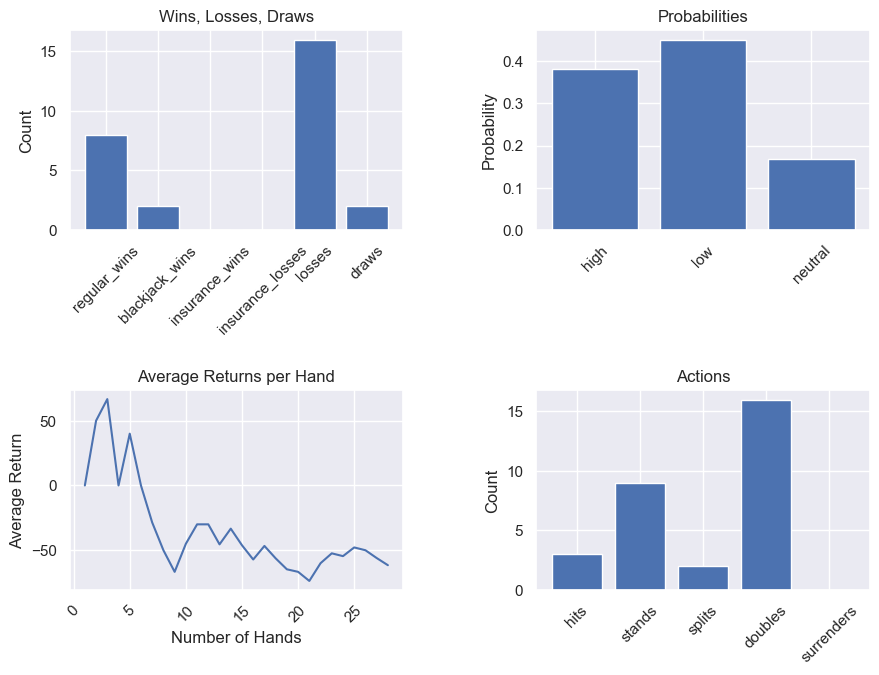

In [11]:
# Create the main window
root = tk.Tk()
game = BlackjackGame(root, 18000, './models/25_model.h5')
game.start_game()
root.mainloop()

### Now, use the prediction from the CNN model to feed the RL model information that will use slightly mislead it from the truth and the RL will have to learn to play blackjack by relying computer vision

In [12]:
class BlackjackEnvironment:
    def __init__(self, model_path: str):
        self.suits = ('hearts', 'diamonds', 'clubs', 'spades')
        self.ranks = {
            'two': 2,
            'three': 3,
            'four': 4,
            'five': 5,
            'six': 6,
            'seven': 7,
            'eight': 8,
            'nine': 9,
            'ten': 10,
            'jack': 10,
            'queen': 10,
            'king': 10,
            'ace': 11
        }

        # Load the trained model
        self.model_path = model_path
        self.model = self.load_model()

        # Initialize the card counter
        self.card_counter = CardCounter(model=self.model)
        self.deck = self.create_deck()

        self._blackjack_wins = 0
        self._regular_wins = 0
        self._insurance_wins = 0
        self._insurance_losses = 0
        self._losses = 0
        self._draws = 0
        self._hits = 0
        self._splits = 0
        self._stands = 0
        self._doubles = 0
        self._surrenders = 0
        self._insurance_used = False
        self._hand_count = 0
        self._active_hand = 0
        self._dealer_hand = []
        self._player_hands = [[]]
        self._dealer_hand_real = []
        self._player_hands_real = [[]]
        self._probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
        self.reset_deck()

    @property
    def blackjack_wins(self):
        return self._blackjack_wins

    @blackjack_wins.setter
    def blackjack_wins(self, blackjack_wins):
        self._blackjack_wins = blackjack_wins

    @property
    def regular_wins(self):
        return self._regular_wins

    @regular_wins.setter
    def regular_wins(self, regular_wins):
        self._regular_wins = regular_wins

    @property
    def insurance_wins(self):
        return self._insurance_wins

    @insurance_wins.setter
    def insurance_wins(self, insurance_wins):
        self._insurance_wins = insurance_wins

    @property
    def insurance_losses(self):
        return self._insurance_losses

    @insurance_losses.setter
    def insurance_losses(self, insurance_losses):
        self._insurance_losses = insurance_losses

    @property
    def insurance_used(self):
        return self._insurance_used

    @insurance_used.setter
    def insurance_used(self, insurance_used):
        self._insurance_used = insurance_used

    @property
    def losses(self):
        return self._losses

    @losses.setter
    def losses(self, losses):
        self._losses = losses

    @property
    def draws(self):
        return self._draws

    @draws.setter
    def draws(self, draws):
        self._draws = draws

    @property
    def hits(self):
        return self._hits

    @hits.setter
    def hits(self, hits):
        self._hits = hits

    @property
    def splits(self):
        return self._splits

    @splits.setter
    def splits(self, splits):
        self._splits = splits

    @property
    def stands(self):
        return self._stands

    @stands.setter
    def stands(self, stands):
        self._stands = stands

    @property
    def doubles(self):
        return self._doubles

    @doubles.setter
    def doubles(self, doubles):
        self._doubles = doubles

    @property
    def surrenders(self):
        return self._surrenders

    @surrenders.setter
    def surrenders(self, surrenders):
        self._surrenders = surrenders

    @property
    def hand_count(self):
        return self._hand_count

    @hand_count.setter
    def hand_count(self, hand_count):
        self._hand_count = hand_count

    @property
    def active_hand(self):
        return self._active_hand

    @active_hand.setter
    def active_hand(self, active_hand):
        self._active_hand = active_hand

    @property
    def dealer_hand(self):
        return self._dealer_hand

    @dealer_hand.setter
    def dealer_hand(self, dealer_hand):
        self._dealer_hand = dealer_hand

    @property
    def player_hands(self):
        return self._player_hands

    @player_hands.setter
    def player_hands(self, player_hands):
        self._player_hands = player_hands

    @property
    def dealer_hand_real(self):
        return self._dealer_hand_real

    @dealer_hand_real.setter
    def dealer_hand_real(self, dealer_hand_real):
        self._dealer_hand_real = dealer_hand_real

    @property
    def player_hands_real(self):
        return self._player_hands_real

    @player_hands_real.setter
    def player_hands_real(self, player_hands_real):
        self._player_hands_real = player_hands_real

    @property
    def probabilities(self):
        return self._probabilities

    @probabilities.setter
    def probabilities(self, probabilities):
        self._probabilities = probabilities

    def load_model(self, use_kan: bool = False):
        input_shape = (224, 224, 3)
        num_classes = 53  # 53 classes for 53 cards

        model = KANCNN(input_shape, num_classes) if use_kan else CNN(input_shape, num_classes)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.load_weights(self.model_path)
        return model

    def create_deck(self):
        deck = [(rank, suit) for rank in self.ranks.keys() for suit in self.suits for _ in
                range(self.card_counter.n_decks)]
        random.shuffle(deck)
        return deck

    def deal_card(self):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()

        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
        predicted_card = predicted_cards[0]

        return card, predicted_card

    def calculate_hand_value(self, hand):
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += self.ranks[rank]

            if rank == 'ace':
                ace_count += 1

        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1

        return value

    def reset(self):
        self.player_hands = [[]]
        self.player_hands_real = [[]]
        self.dealer_hand_real = []
        self.dealer_hand = []
        self.active_hand = 0
        
        first_player_card, first_player_predicted_card = self.deal_card()
        first_dealer_card, first_dealer_predicted_card = self.deal_card()
        second_player_card, second_player_predicted_card = self.deal_card()
        second_dealer_card, second_dealer_predicted_card = self.deal_card()
        
        self.player_hands[self.active_hand].append(first_player_predicted_card)
        self.player_hands_real[self.active_hand].append(first_player_card)
        self.dealer_hand.append(first_dealer_predicted_card)
        self.dealer_hand_real.append(first_dealer_card)
        self.player_hands[self.active_hand].append(second_player_predicted_card)
        self.player_hands_real[self.active_hand].append(second_player_card)
        self.dealer_hand.append(second_dealer_predicted_card)
        self.dealer_hand_real.append(second_dealer_card)

        self.insurance_used = False
        
        return self.get_state()

    def reset_deck(self):
        self.deck = self.create_deck()
        self.card_counter.reset_deck()
        self.probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}

    def get_state(self):
        player_hand_value = self.calculate_hand_value(self.player_hands[self.active_hand])
        dealer_upcard = self.ranks[self.dealer_hand[0][0]]
        usable_a = any(card[0] == 'ace' for card in self.player_hands[self.active_hand]) and self.calculate_hand_value(self.player_hands[self.active_hand]) + 10 <= 21
        can_split = len(self.player_hands_real[self.active_hand]) == 2 and self.player_hands_real[self.active_hand][0][0] == self.player_hands_real[self.active_hand][1][0]
        can_surrender = len(self.player_hands) == 1 and len(self.player_hands[0]) == 2
        can_insure = self.dealer_hand[0][0] == 'ace' and not self.insurance_used
        return (player_hand_value, dealer_upcard, usable_a, len(self.player_hands), can_insure, can_surrender, can_split)

    def step(self, action):
        if action == 'double':
            self.doubles += 1
            card, predicted_card = self.deal_card()
            self.player_hands_real[self.active_hand].append(card)
            self.player_hands[self.active_hand].append(predicted_card)
            player_value = self.calculate_hand_value(self.player_hands_real[self.active_hand])
            dealer_value = self.calculate_hand_value(self.dealer_hand_real)

            if player_value > 21:
                self.losses += 1
                reward = -2
            elif player_value == 21:
                self.blackjack_wins += 1
                reward = 3
            elif player_value > dealer_value or dealer_value > 21:
                self.regular_wins += 1
                reward = 2
            elif player_value < dealer_value <= 21:
                self.losses += 1
                reward = -2
            else:
                self.draws += 1
                reward = 0

            if self.active_hand < len(self.player_hands) - 1:
                done = False
                self.active_hand += 1
            else:
                done = True

            return self.get_state(), reward, done

        elif action == 'surrender' and len(self.player_hands_real) == 1 and len(self.player_hands_real[0]) == 2:
            self.surrenders += 1
            reward = -0.5
            done = True
            return self.get_state(), reward, done

        elif action == 'insurance' and not self.insurance_used and self.dealer_hand_real[0][0] == 'ace':
            self.insurance_used = True
            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            if dealer_value == 21:
                self.insurance_wins += 1
                reward = 1
            else:
                self.insurance_losses += 1
                reward = -0.5

            done = False
            return self.get_state(), reward, done

        elif action == 'hit':
            continue_flag = False
            self.hits += 1
            card, predicted_card = self.deal_card()
            self.player_hands_real[self.active_hand].append(card)
            self.player_hands[self.active_hand].append(predicted_card)
            player_value = self.calculate_hand_value(self.player_hands_real[self.active_hand])
            if player_value > 21:
                self.losses += 1
                reward = -1
            elif player_value == 21:
                self.blackjack_wins += 1
                reward = 1.5
            else:
                reward = 0
                continue_flag = True

            if self.active_hand < len(self.player_hands) - 1:
                done = False
                self.active_hand += 1
            else:
                if continue_flag:
                    done = False
                else:
                    done = True

            return self.get_state(), reward, done

        elif action == 'stand':
            self.stands += 1
            if self.active_hand < len(self.player_hands) - 1:
                self.active_hand += 1
                reward = 0
                done = False
                return self.get_state(), reward, done

            while self.calculate_hand_value(self.dealer_hand_real) < 17:
                card, predicted_card = self.deal_card()
                self.dealer_hand.append(predicted_card)
                self.dealer_hand_real.append(card)

            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            rewards = 0
            for hand in self.player_hands_real:
                player_value = self.calculate_hand_value(hand)
                if player_value == 21:
                    rewards += 1.5
                    self.blackjack_wins += 1
                elif player_value < dealer_value <= 21:
                    rewards -= 1
                    self.losses += 1
                elif dealer_value > 21 or player_value > dealer_value:
                    rewards += 1
                    self.regular_wins += 1
                elif player_value == dealer_value and player_value < 21:
                    self.draws += 1

            done = True
            return self.get_state(), rewards, done

        elif action == 'split' and len(self.player_hands_real[self.active_hand]) == 2 and \
                self.player_hands_real[self.active_hand][0][0] == self.player_hands_real[self.active_hand][1][0]:
            self.splits += 1
            first_card, first_predicted_card = self.deal_card()
            second_card, second_predicted_card = self.deal_card()
            new_hand = [self.player_hands[self.active_hand].pop()]
            new_real_hand = [self.player_hands_real[self.active_hand].pop()]

            self.player_hands_real[self.active_hand].append(first_card)
            self.player_hands[self.active_hand].append(first_predicted_card)
            new_hand.append(second_predicted_card)
            new_real_hand.append(second_card)

            self.player_hands_real.append(new_real_hand)
            self.player_hands.append(new_hand)
            reward = 0
            done = False
            return self.get_state(), reward, done

        return self.get_state(), 0, False


class QLearningAgent:
    def __init__(self, action_space, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(len(action_space)))
        self.actions = action_space
        self.rewards = []
        self.action_counts = defaultdict(int)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            available_actions = self.actions if state[6] else [a for a in self.actions if a != 'split']
            available_actions = available_actions if state[5] else [a for a in self.actions if a != 'surrender']
            available_actions = available_actions if state[4] else [a for a in self.actions if a != 'insurance']
            action = np.random.choice(available_actions)
        else:
            q_values = self.q_table[state]
            if not state[6]:
                self.q_table[state][self.actions.index('split')] = -float('inf')

            if not state[5]:
                self.q_table[state][self.actions.index('surrender')] = -float('inf')

            if not state[4]:
                self.q_table[state][self.actions.index('insurance')] = -float('inf')

            action = self.actions[np.argmax(q_values)]

        self.action_counts[action] += 1
        return action

    def update_q_value(self, state, action, reward, next_state):
        if not state[6]:
            self.q_table[state][self.actions.index('split')] = -float('inf')

        if not next_state[6]:
            self.q_table[next_state][self.actions.index('split')] = -float('inf')

        if not state[5]:
            self.q_table[state][self.actions.index('surrender')] = -float('inf')

        if not next_state[5]:
            self.q_table[next_state][self.actions.index('surrender')] = -float('inf')

        if not state[4]:
            self.q_table[state][self.actions.index('insurance')] = -float('inf')

        if not next_state[4]:
            self.q_table[next_state][self.actions.index('insurance')] = -float('inf')

        action_idx = self.actions.index(action)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        self.q_table[state][action_idx] += self.alpha * (td_target - self.q_table[state][action_idx])

    def train(self, environment, episodes):
        for episode in range(episodes):
            state = environment.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward

            self.rewards.append(total_reward)

        return self.rewards

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)

    def load_model(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = defaultdict(lambda: np.zeros(len(self.actions)), pickle.load(f))


class BlackjackRL:
    def __init__(self, root, agent, environment, train_episodes, test_episodes, cnn_model_path):
        self.root = root
        self.root.title("Blackjack RL Agent")
        self.agent = agent
        self.environment = environment
        self.train_episodes = train_episodes
        self.test_episodes = test_episodes
        self._probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
        self.card_images = []
        self.game_log = []
        self.training = False

        # Set window size as a percentage of screen size
        self.window_width = int(self.root.winfo_screenwidth() * 0.95)
        self.window_height = int(self.root.winfo_screenheight() * 0.9)
        self.root.geometry(f"{self.window_width}x{self.window_height}")

        # Calculate padding as percentages of screen dimensions
        self.padx = int(self.window_width * 0.01)
        self.pady = int(self.window_height * 0.01)
        self.num_columns = 4

        # Load the trained model
        self.cnn_model_path = cnn_model_path
        self.cnn_model = self.load_cnn_model()
        self.card_counter = CardCounter(model=self.cnn_model)

        # Create main frames
        self.main_frame = tk.Frame(self.root)
        self.main_frame.pack(side=tk.LEFT, padx=self.padx, pady=self.pady, expand=True, fill='both')

        self.stats_frame = tk.Frame(self.root)
        self.stats_frame.pack(side=tk.RIGHT, padx=self.padx, pady=self.pady * 4, expand=True, fill='both')

        self.game_frame = tk.Frame(self.main_frame)
        self.game_frame.pack(side=tk.TOP, expand=True, fill='both')

        # Store initial size of the game frame
        self.initial_game_frame_size = (self.window_width // 2, self.window_height)

        # Create game widgets
        self._player_label = tk.Label(self.game_frame, text="Player's Hand")
        self._player_label.grid(row=0, column=0, columnspan=self.num_columns)
        self._player_frames = [tk.Frame(self.game_frame) for _ in range(4)]
        for idx, frame in enumerate(self._player_frames):
            frame.grid(row=1, column=idx, padx=self.padx, pady=self.pady, sticky='nsew')

        self._dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self._dealer_label.grid(row=2, column=0, pady=self.pady)
        self._dealer_frame = tk.Frame(self.game_frame)
        self._dealer_frame.grid(row=3, column=0, columnspan=self.num_columns, padx=self.padx, pady=self.pady,
                                sticky='nsew')

        self._start_button = tk.Button(self.game_frame, text="Start Training", command=self.start_training)
        self._start_button.grid(row=4, column=0, padx=self.padx, pady=self.pady)
        self._stop_button = tk.Button(self.game_frame, text="Stop Training", command=self.stop_training,
                                      state=tk.DISABLED)
        self._stop_button.grid(row=4, column=1, padx=self.padx, pady=self.pady)
        self._save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self._save_button.grid(row=5, column=0, padx=self.padx, pady=self.pady)
        self._load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self._load_button.grid(row=5, column=1, padx=self.padx, pady=self.pady)

        self._test_button = tk.Button(self.game_frame, text="Test Agent",
                                      command=lambda: self.test_agent(games=test_episodes), state=tk.DISABLED)
        self._test_button.grid(row=6, column=0, columnspan=self.num_columns, pady=self.pady)

        # Create stats widgets with adjusted sizes
        fig_width = self.window_width / 4 / 100
        fig_height = self.window_height / 3.5 / 100

        # Create stats widgets
        self.cumulative_rewards_fig, self.cumulative_rewards_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.cumulative_rewards_canvas = FigureCanvasTkAgg(self.cumulative_rewards_fig, master=self.stats_frame)
        self.cumulative_rewards_canvas.get_tk_widget().grid(row=0, column=0, pady=self.pady)
        self.cumulative_rewards_fig.subplots_adjust(bottom=0.3)

        self.average_rewards_fig, self.average_rewards_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.average_rewards_canvas = FigureCanvasTkAgg(self.average_rewards_fig, master=self.stats_frame)
        self.average_rewards_canvas.get_tk_widget().grid(row=0, column=1, pady=self.pady)
        self.average_rewards_fig.subplots_adjust(bottom=0.3)

        self.win_loss_fig, self.win_loss_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.win_loss_canvas = FigureCanvasTkAgg(self.win_loss_fig, master=self.stats_frame)
        self.win_loss_canvas.get_tk_widget().grid(row=1, column=0, pady=self.pady)
        self.win_loss_fig.subplots_adjust(bottom=0.3)

        self.prob_fig, self.prob_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.prob_canvas = FigureCanvasTkAgg(self.prob_fig, master=self.stats_frame)
        self.prob_canvas.get_tk_widget().grid(row=1, column=1, pady=self.pady)
        self.prob_fig.subplots_adjust(bottom=0.3)

        self.q_values_fig, self.q_values_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.q_values_canvas = FigureCanvasTkAgg(self.q_values_fig, master=self.stats_frame)
        self.q_values_canvas.get_tk_widget().grid(row=2, column=0, pady=self.pady)
        self.q_values_fig.subplots_adjust(bottom=0.3)

        self.action_counts_fig, self.action_counts_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.action_counts_canvas = FigureCanvasTkAgg(self.action_counts_fig, master=self.stats_frame)
        self.action_counts_canvas.get_tk_widget().grid(row=2, column=1, pady=self.pady)
        self.action_counts_fig.subplots_adjust(bottom=0.3)

        # Create a scrollable text widget for logs
        self.log_frame = tk.Frame(self.main_frame)
        self.log_frame.pack(side=tk.BOTTOM, fill='both')
        self.log_text = tk.Text(self.log_frame, wrap=tk.WORD, state=tk.NORMAL, width=80, height=25)
        self.log_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.log_scrollbar = ttk.Scrollbar(self.log_frame, command=self.log_text.yview)
        self.log_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.log_text.config(yscrollcommand=self.log_scrollbar.set)

        self.episode_count = 0

    @property
    def probabilities(self):
        return self._probabilities

    @probabilities.setter
    def probabilities(self, probabilities):
        self._probabilities = probabilities

    @property
    def player_label(self):
        return self._player_label

    @player_label.setter
    def player_label(self, player_label):
        self._player_label = player_label

    @property
    def player_frames(self):
        return self._player_frames

    @player_frames.setter
    def player_frames(self, player_frames):
        self._player_frames = player_frames

    @property
    def dealer_label(self):
        return self._dealer_label

    @dealer_label.setter
    def dealer_label(self, dealer_label):
        self._dealer_label = dealer_label

    @property
    def dealer_frame(self):
        return self._dealer_frame

    @dealer_frame.setter
    def dealer_frame(self, dealer_frame):
        self._dealer_frame = dealer_frame

    @property
    def start_button(self):
        return self._start_button

    @start_button.setter
    def start_button(self, start_button):
        self._start_button = start_button

    @property
    def stop_button(self):
        return self._stop_button

    @stop_button.setter
    def stop_button(self, stop_button):
        self._stop_button = stop_button

    @property
    def save_button(self):
        return self._save_button

    @save_button.setter
    def save_button(self, save_button):
        self._save_button = save_button

    @property
    def load_button(self):
        return self._load_button

    @load_button.setter
    def load_button(self, load_button):
        self._load_button = load_button

    @property
    def test_button(self):
        return self._test_button

    @test_button.setter
    def test_button(self, test_button):
        self._test_button = test_button

    def reinitialize_game_frame(self):
        # Create game widgets
        self.player_label = tk.Label(self.game_frame, text="Player's Hand")
        self.player_label.grid(row=0, column=0, columnspan=self.num_columns)
        self.player_frames = [tk.Frame(self.game_frame) for _ in range(4)]
        for idx, frame in enumerate(self.player_frames):
            frame.grid(row=1, column=idx, padx=self.padx, pady=self.pady, sticky='nsew')

        self.dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self.dealer_label.grid(row=2, column=0, pady=self.pady)
        self.dealer_frame = tk.Frame(self.game_frame)
        self.dealer_frame.grid(row=3, column=0, columnspan=self.num_columns, padx=self.padx, pady=self.pady,
                               sticky='nsew')

        self.start_button = tk.Button(self.game_frame, text="Start Training", command=self.start_training,
                                     state=tk.DISABLED)
        self.start_button.grid(row=4, column=0, padx=self.padx, pady=self.pady)
        self.stop_button = tk.Button(self.game_frame, text="Stop Training", command=self.stop_training)
        self.stop_button.grid(row=4, column=1, padx=self.padx, pady=self.pady)
        self.save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self.save_button.grid(row=5, column=0, padx=self.padx, pady=self.pady)
        self.load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self.load_button.grid(row=5, column=1, padx=self.padx, pady=self.pady)

        self.test_button = tk.Button(self.game_frame, text="Test Agent",
                                     command=lambda: self.test_agent(games=self.test_episodes), state=tk.DISABLED)
        self.test_button.grid(row=6, column=0, columnspan=self.num_columns, pady=self.pady)

    def load_cnn_model(self, use_kan: bool = False):
        input_shape = (224, 224, 3)
        num_classes = 53  # 53 classes for 53 cards

        model = KANCNN(input_shape, num_classes) if use_kan else CNN(input_shape, num_classes)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.load_weights(self.cnn_model_path)
        return model

    def save_rl_model(self):
        file_path = filedialog.asksaveasfilename(defaultextension=".h5", filetypes=[("H5 files", "*.h5"), ("PKL files", "*.pkl"), ("All files", "*.*")])
        if file_path:
            self.agent.save_model(file_path)
            print(f"Model saved to: {file_path}")

    def load_rl_model(self):
        file_path = filedialog.askopenfilename(filetypes=[("H5 files", "*.h5"), ("PKL files", "*.pkl"), ("All files", "*.*")])
        if file_path:
            self.agent.load_model(file_path)
            print(f"Model loaded from: {file_path}")

    def update_stats(self):
        # Update cumulative rewards plot
        cumulative_rewards = np.cumsum(self.agent.rewards)
        self.cumulative_rewards_ax.clear()
        self.cumulative_rewards_ax.plot(range(1, len(cumulative_rewards) + 1), cumulative_rewards, label='Cumulative Reward')
        self.cumulative_rewards_ax.set_xlabel('Episode')
        self.cumulative_rewards_ax.set_ylabel('Cumulative Reward')
        self.cumulative_rewards_ax.set_title('Cumulative Rewards Over Time')
        self.cumulative_rewards_ax.legend()
        self.cumulative_rewards_canvas.draw()

        # Update average rewards plot
        average_rewards = cumulative_rewards / (np.arange(len(self.agent.rewards)) + 1)
        self.average_rewards_ax.clear()
        self.average_rewards_ax.plot(range(1, len(average_rewards) + 1), average_rewards, label='Average Reward per Episode')
        self.average_rewards_ax.set_xlabel('Episode')
        self.average_rewards_ax.set_ylabel('Average Reward')
        self.average_rewards_ax.set_title('Average Rewards Over Time')
        self.average_rewards_ax.legend()
        self.average_rewards_canvas.draw()

        # Update win/loss plot
        win_data = {
            "Regular Wins": self.environment.regular_wins,
            "Blackjack Wins": self.environment.blackjack_wins,
            "Insurance Wins": self.environment.insurance_wins,
            "Insurance Losses": self.environment.insurance_losses,
            "Losses": self.environment.losses,
            "Draws": self.environment.draws
        }
        self.win_loss_ax.clear()
        self.win_loss_ax.bar(win_data.keys(), win_data.values())
        self.win_loss_ax.set_title("Wins, Losses, Draws")
        self.win_loss_ax.set_ylabel("Count")
        self.win_loss_ax.tick_params(axis='x', rotation=45)
        self.win_loss_canvas.draw()

        # Update probability plot
        prob_data = {
            "High": self.probabilities["High"][-1],
            "Low": self.probabilities["Low"][-1],
            "Neutral": self.probabilities["Neutral"][-1]
        }
        self.prob_ax.clear()
        self.prob_ax.bar(prob_data.keys(), prob_data.values())
        self.prob_ax.set_title("Card Probabilities")
        self.prob_ax.set_ylabel("Count")
        self.prob_canvas.draw()

        # Update Q-values plot
        state = self.environment.get_state()
        q_values = self.agent.q_table[state]
        if not state[6]:
            q_values[self.agent.actions.index('split')] = 0

        if not state[5]:
            q_values[self.agent.actions.index('surrender')] = 0

        if not state[4]:
            q_values[self.agent.actions.index('insurance')] = 0

        self.q_values_ax.clear()
        self.q_values_ax.bar(self.agent.actions, q_values)
        self.q_values_ax.set_xlabel('Actions')
        self.q_values_ax.set_ylabel('Q-values')
        self.q_values_ax.set_title('Q-values for Current State')
        self.q_values_canvas.draw()

        # Update action counts plot
        actions = list(self.agent.action_counts.keys())
        counts = list(self.agent.action_counts.values())
        self.action_counts_ax.clear()
        self.action_counts_ax.bar(actions, counts)
        self.action_counts_ax.set_xlabel('Actions')
        self.action_counts_ax.set_ylabel('Counts')
        self.action_counts_ax.set_title('Action Selection Frequency')
        self.action_counts_canvas.draw()

    def log_message(self, message):
        message = f'Episode {self.episode_count}: {message}'
        self.game_log.append(message)
        self.log_text.config(state=tk.NORMAL)
        self.log_text.insert(tk.END, message + "\n")
        self.log_text.config(state=tk.NORMAL)
        self.log_text.yview(tk.END)

    def start_training(self):
        self.training = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        self.test_button.config(state=tk.DISABLED)
        self.train_agent()

    def stop_training(self):
        self.training = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)
        self.test_button.config(state=tk.NORMAL)

    def reset_game(self):
        self.environment.reset()
        self.clear_frames(self.player_frames)
        self.clear_frames([self.dealer_frame])

        for widget in self.game_frame.winfo_children():
            widget.destroy()

        # Reset the size of the game_frame
        self.reinitialize_game_frame()
        self.update_stats()

    def clear_frames(self, frames):
        for frame in frames:
            for widget in frame.winfo_children():
                widget.destroy()

    def train_agent(self):
        if not self.training:
            return

        self.reset_game()
        state = self.environment.reset()
        done = False
        while not done:
            self.root.update_idletasks()
            self.root.update()
            action = self.agent.choose_action(state)
            self.log_message(f"Player Hand: {self.environment.player_hands[self.environment.active_hand]}")
            self.log_message(f"Action: {action}")
            next_state, reward, done = self.environment.step(action)
            self.agent.update_q_value(state, action, reward, next_state)
            state = next_state
            self.update_hand_display()
            if done:
                self.episode_count += 1
                self.agent.rewards.append(reward)
                self.update_stats()
                self.log_message(f"Reward {reward}")
                self.root.after(1000, self.train_agent)
                break

            self.root.after(1000, lambda: None)  # Add delay for visualization

    def update_hand_display(self):
        if not self.root:
            return

        # Update player hands without clearing frames
        for idx, player_hand in enumerate(self.environment.player_hands_real):
            for card_idx, card in enumerate(player_hand):
                predicted_card = self.environment.player_hands[idx][card_idx]
                img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
                if os.path.exists(img_path):
                    try:
                        img = Image.open(img_path)
                        img = img.resize((100, 150), Image.LANCZOS)
                        photo = ImageTk.PhotoImage(img)
                        self.card_images.append(photo)  # Keep a reference to the image
                        frame = self.player_frames[idx]
                        label = tk.Label(frame, image=photo)
                        label.image = photo  # Ensure reference is kept by the label
                        label.grid(row=0, column=card_idx, padx=self.padx // 2, pady=self.pady // 2)
                        frame_text = f'Actual: {card[0]} of {card[1]}\nPredicted: {predicted_card[0]} of {predicted_card[1]}'
                        tk.Label(frame, text=frame_text).grid(row=1, column=card_idx, padx=self.padx // 2,
                                                              pady=self.pady // 2)
                    except Exception as e:
                        print(f"Failed to load image {img_path}: {e}")

        # Update dealer hand
        for idx, dealer_card in enumerate(self.environment.dealer_hand_real):
            img_path = f'./data/test/{dealer_card[0]} of {dealer_card[1]}/1.jpg'
            dealer_predicted_card = self.environment.dealer_hand[idx]
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path)
                    img = img.resize((100, 150), Image.LANCZOS)
                    photo = ImageTk.PhotoImage(img)
                    self.card_images.append(photo)  # Keep a reference to the image
                    frame = self.dealer_frame
                    label = tk.Label(frame, image=photo)
                    label.image = photo  # Ensure reference is kept by the label
                    label.grid(row=0, column=idx, padx=self.padx // 2, pady=self.pady // 2)
                    frame_text = f'Actual: {dealer_card[0]} of {dealer_card[1]}\nPredicted: {dealer_predicted_card[0]} of {dealer_predicted_card[1]}'
                    tk.Label(frame, text=frame_text).grid(row=1, column=idx, padx=self.padx // 2,
                                                          pady=self.pady // 2)
                except Exception as e:
                    print(f"Failed to load image {img_path}: {e}")

    def test_agent(self, games=100):
        wins, losses, draws = 0, 0, 0
        for _ in range(games):
            state = self.environment.reset()
            done = False
            while not done:
                action = self.agent.choose_action(state)
                next_state, reward, done = self.environment.step(action)
                state = next_state
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1

        messagebox.showinfo("Test Results", f"Results over {games} games:\nWins: {wins}\nLosses: {losses}\nDraws: {draws}")

    def start(self):
        self.root.mainloop()

Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1

C:\Users\Amram\AppData\Local\Temp\ipykernel_50336\2789157168.py:478: RuntimeWarning: invalid value encountered in scalar add
  self.q_table[state][action_idx] += self.alpha * (td_target - self.q_table[state][action_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

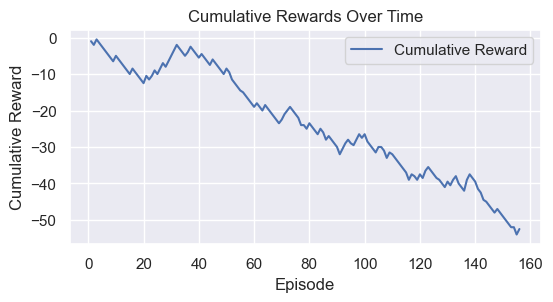

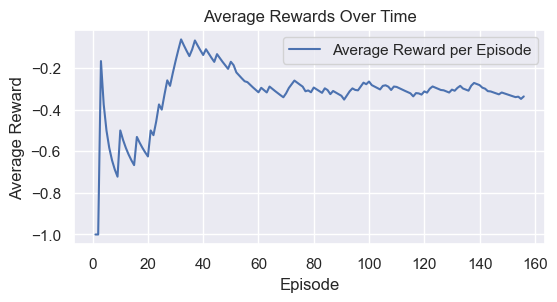

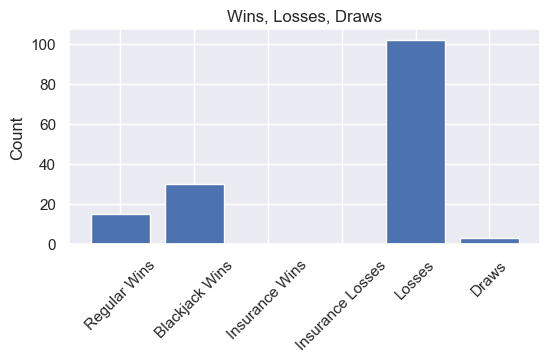

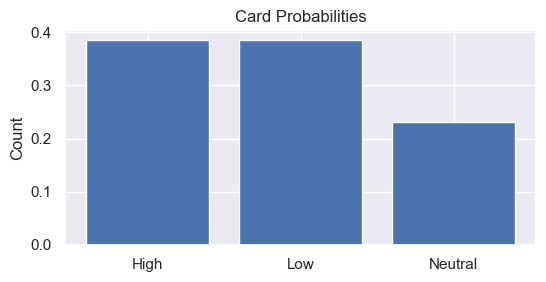

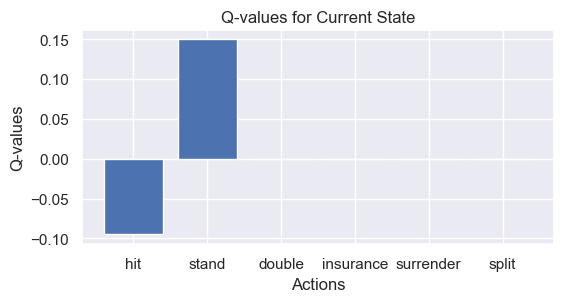

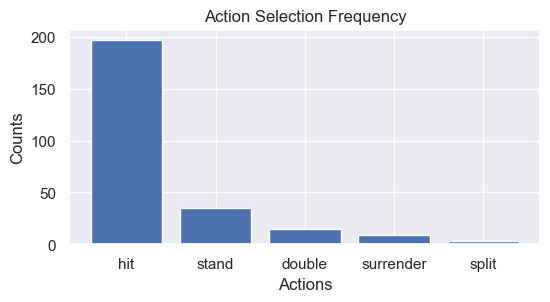

In [13]:
# Create a Q-Learning Reinforcement Learning model to learn to play blackjack
epochs = 25
model_path = f'./models/{epochs}_model.h5'
env = BlackjackEnvironment(model_path)
actions = ['hit', 'stand', 'double', 'insurance', 'surrender', 'split']
agent = QLearningAgent(action_space=actions)
root = tk.Tk()
app = BlackjackRL(
    root=root,
    agent=agent,
    environment=env,
    train_episodes=10000,
    test_episodes=1000,
    cnn_model_path=model_path
)

app.start()

# Now to use Deep Q Learning (DQN) in order to get the reinforcement learning model to take the probabilities of the card counter into account

In [14]:
class DuelingDQN(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(state_size)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.LeakyReLU(alpha=0.01)

        self.fc2 = tf.keras.layers.Dense(128)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.LeakyReLU(alpha=0.01)

        self.fc3 = tf.keras.layers.Dense(64)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.act3 = tf.keras.layers.LeakyReLU(alpha=0.01)

        self.dropout = tf.keras.layers.Dropout(0.5)

        # Separate streams for state value and advantage
        self.value_stream = tf.keras.layers.Dense(1)
        self.advantage_stream = tf.keras.layers.Dense(action_size)

    def call(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.dropout(x)

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine value and advantage to get Q-values
        q_values = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        return q_values


class DQNAgent:
    def __init__(self, state_size, action_space, gamma=0.99, epsilon=0.1, epsilon_min=0.01, epsilon_decay=0.995,
                 learning_rate=0.001, batch_size=128, target_update_freq=10):
        self.state_size = state_size
        self.action_size = len(action_space)
        self.action_space = action_space
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=self.learning_rate,
            decay_steps=10000,
            decay_rate=0.96,
            staircase=False)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)
        self.criterion = tf.keras.losses.MeanSquaredError()
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.rewards = []
        self.losses = []
        self.learning_rates = []
        self.action_counts = defaultdict(int)
        self.target_update_freq = target_update_freq
        self.episode_count = 0
        self.training_step = 0
        self.update_target_network()

    def create_model(self):
        model = DuelingDQN(self.state_size, self.action_size)
        model.compile(optimizer=self.optimizer)
        return model

    def remember(self, state, action, reward, next_state, done):
        action_idx = self.action_space.index(action)
        self.memory.append((state, action_idx, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            available_actions = self.action_space if state[-1] else [a for a in self.action_space if a != 'split']
            available_actions = available_actions if state[-2] else [a for a in self.action_space if a != 'surrender']
            available_actions = available_actions if state[-3] else [a for a in self.action_space if a != 'insurance']
            chosen_action = random.choice(available_actions)
            action_idx = self.action_space.index(chosen_action)
            self.action_counts[self.action_space[action_idx]] += 1
            return chosen_action

        state = tf.convert_to_tensor([state], dtype=tf.float32)
        act_values = self.model(state)[0]
        if not state[0][-1]:
            act_values = tf.tensor_scatter_nd_update(act_values, [[self.action_space.index('split')]], [-float('inf')])

        if not state[0][-2]:
            act_values = tf.tensor_scatter_nd_update(act_values, [[self.action_space.index('surrender')]], [-float('inf')])

        if not state[0][-3]:
            act_values = tf.tensor_scatter_nd_update(act_values, [[self.action_space.index('insurance')]], [-float('inf')])

        action_idx = tf.argmax(act_values).numpy()
        self.action_counts[self.action_space[action_idx]] += 1
        return self.action_space[action_idx]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        losses = []
        learning_rates = []
        for state, action_idx, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)
                next_action = tf.argmax(self.model(next_state)[0]).numpy()
                target += self.gamma * self.target_model(next_state)[0][next_action].numpy()

            state = tf.convert_to_tensor([state], dtype=tf.float32)
            target_f = self.model(state).numpy()
            target_f[0][action_idx] = target
            with tf.GradientTape() as tape:
                predictions = self.model(state)
                loss = self.criterion(target_f, predictions)
                losses.append(np.mean(loss.numpy()))

            learning_rates.append(self.lr_schedule(self.training_step).numpy())
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            self.training_step += 1

        self.losses.append(np.mean(losses))
        self.learning_rates.append(np.mean(learning_rates))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.update_target_network_periodically()

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def update_target_network_periodically(self):
        if self.episode_count % self.target_update_freq == 0:
            self.update_target_network()

    def save_model(self, name):
        extensionless_name = name.split('model.weights.h5')[0]
        self.model.save_weights(f"{extensionless_name}model.weights.h5")
        self.target_model.save_weights(f"{extensionless_name}target_model.weights.h5")

    def load_model(self, name):
        target_name = f"{name.split('model.weights.h5')[0]}target_model.weights.h5"
        self.model.load_weights(name)
        self.target_model.load_weights(target_name)


class DQNBlackjackEnvironment:
    def __init__(self, model_path):
        self.suits = ('hearts', 'diamonds', 'clubs', 'spades')
        self.ranks = {
            'two': 2,
            'three': 3,
            'four': 4,
            'five': 5,
            'six': 6,
            'seven': 7,
            'eight': 8,
            'nine': 9,
            'ten': 10,
            'jack': 10,
            'queen': 10,
            'king': 10,
            'ace': 11
        }

        # Load the trained model
        self.model_path = model_path
        self.model = self.load_model()

        # Initialize the card counter
        self.card_counter = CardCounter(model=self.model)
        self.deck = self.create_deck()

        self._blackjack_wins = 0
        self._regular_wins = 0
        self._insurance_wins = 0
        self._insurance_losses = 0
        self._losses = 0
        self._draws = 0
        self._hits = 0
        self._splits = 0
        self._stands = 0
        self._doubles = 0
        self._surrenders = 0
        self._hand_count = 0
        self._active_hand = 0
        self._dealer_hand = []
        self._player_hands = [[]]
        self._dealer_hand_real = []
        self._player_hands_real = [[]]
        self._probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
        self._insurance_used = False
        self.reset_deck()

    @property
    def blackjack_wins(self):
        return self._blackjack_wins

    @blackjack_wins.setter
    def blackjack_wins(self, blackjack_wins):
        self._blackjack_wins = blackjack_wins

    @property
    def regular_wins(self):
        return self._regular_wins

    @regular_wins.setter
    def regular_wins(self, regular_wins):
        self._regular_wins = regular_wins

    @property
    def insurance_wins(self):
        return self._insurance_wins

    @insurance_wins.setter
    def insurance_wins(self, insurance_wins):
        self._insurance_wins = insurance_wins

    @property
    def insurance_losses(self):
        return self._insurance_losses

    @insurance_losses.setter
    def insurance_losses(self, insurance_losses):
        self._insurance_losses = insurance_losses

    @property
    def losses(self):
        return self._losses

    @losses.setter
    def losses(self, losses):
        self._losses = losses

    @property
    def draws(self):
        return self._draws

    @draws.setter
    def draws(self, draws):
        self._draws = draws

    @property
    def hits(self):
        return self._hits

    @hits.setter
    def hits(self, hits):
        self._hits = hits

    @property
    def splits(self):
        return self._splits

    @splits.setter
    def splits(self, splits):
        self._splits = splits

    @property
    def stands(self):
        return self._stands

    @stands.setter
    def stands(self, stands):
        self._stands = stands

    @property
    def doubles(self):
        return self._doubles

    @doubles.setter
    def doubles(self, doubles):
        self._doubles = doubles

    @property
    def surrenders(self):
        return self._surrenders

    @surrenders.setter
    def surrenders(self, surrenders):
        self._surrenders = surrenders

    @property
    def hand_count(self):
        return self._hand_count

    @hand_count.setter
    def hand_count(self, hand_count):
        self._hand_count = hand_count

    @property
    def active_hand(self):
        return self._active_hand

    @active_hand.setter
    def active_hand(self, active_hand):
        self._active_hand = active_hand

    @property
    def dealer_hand(self):
        return self._dealer_hand

    @dealer_hand.setter
    def dealer_hand(self, dealer_hand):
        self._dealer_hand = dealer_hand

    @property
    def player_hands(self):
        return self._player_hands

    @player_hands.setter
    def player_hands(self, player_hands):
        self._player_hands = player_hands

    @property
    def dealer_hand_real(self):
        return self._dealer_hand_real

    @dealer_hand_real.setter
    def dealer_hand_real(self, dealer_hand_real):
        self._dealer_hand_real = dealer_hand_real

    @property
    def player_hands_real(self):
        return self._player_hands_real

    @player_hands_real.setter
    def player_hands_real(self, player_hands_real):
        self._player_hands_real = player_hands_real

    @property
    def probabilities(self):
        return self._probabilities

    @probabilities.setter
    def probabilities(self, probabilities):
        self._probabilities = probabilities

    @property
    def insurance_used(self):
        return self._insurance_used

    @insurance_used.setter
    def insurance_used(self, insurance_used):
        self._insurance_used = insurance_used

    def load_model(self, use_kan: bool = False):
        input_shape = (224, 224, 3)
        num_classes = 53  # 53 classes for 53 cards

        model = KANCNN(input_shape, num_classes) if use_kan else CNN(input_shape, num_classes)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.load_weights(self.model_path)
        return model

    def create_deck(self):
        deck = [(rank, suit) for rank in self.ranks.keys() for suit in self.suits for _ in
                range(self.card_counter.n_decks)]
        random.shuffle(deck)
        return deck

    def deal_card(self):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            self.probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}

        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
        predicted_card = predicted_cards[0]

        return card, predicted_card

    def calculate_hand_value(self, hand):
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += self.ranks[rank]

            if rank == 'ace':
                ace_count += 1

        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1

        return value

    def reset(self):
        self.player_hands = [[]]
        self.player_hands_real = [[]]
        self.dealer_hand_real = []
        self.dealer_hand = []
        self.active_hand = 0

        first_player_card, first_player_predicted_card = self.deal_card()
        first_dealer_card, first_dealer_predicted_card = self.deal_card()
        second_player_card, second_player_predicted_card = self.deal_card()
        second_dealer_card, second_dealer_predicted_card = self.deal_card()

        self.player_hands[self.active_hand].append(first_player_predicted_card)
        self.player_hands_real[self.active_hand].append(first_player_card)
        self.dealer_hand.append(first_dealer_predicted_card)
        self.dealer_hand_real.append(first_dealer_card)
        self.player_hands[self.active_hand].append(second_player_predicted_card)
        self.player_hands_real[self.active_hand].append(second_player_card)
        self.dealer_hand.append(second_dealer_predicted_card)
        self.dealer_hand_real.append(second_dealer_card)

        self.insurance_used = False

        return self.get_state()

    def reset_deck(self):
        self.deck = self.create_deck()
        self.card_counter.reset_deck()
        self.probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}

    def one_hot_encode_rank(self, rank):
        ranks = [*self.ranks.keys()]
        encoding = [0] * len(ranks)
        encoding[ranks.index(rank)] = 1
        return encoding

    def get_state(self):
        player_hand_value = self.calculate_hand_value(self.player_hands[self.active_hand])
        dealer_visible_card = self.one_hot_encode_rank(self.dealer_hand[0][0])
        usable_a = self.usable_ace(self.player_hands[self.active_hand])
        return [player_hand_value] + dealer_visible_card + [usable_a] + [self.probabilities['High'][-1], self.probabilities['Low'][-1], self.probabilities['Neutral'][-1], self.can_insure(), self.can_surrender(), self.can_split()]

    def can_insure(self):
        return self.dealer_hand[0][0] == 'ace' and not self.insurance_used

    def can_surrender(self):
        return len(self.player_hands) == 1 and len(self.player_hands[0]) == 2

    def can_split(self):
        return len(self.player_hands[self.active_hand]) == 2 and self.player_hands[self.active_hand][0][0] == self.player_hands[self.active_hand][1][0]

    def usable_ace(self, hand):
        return 1 in [card[0] == 'ace' for card in hand] and self.calculate_hand_value(hand) + 10 <= 21

    def step(self, action):
        if action == 'double':
            self.doubles += 1
            card, predicted_card = self.deal_card()
            self.player_hands_real[self.active_hand].append(card)
            self.player_hands[self.active_hand].append(predicted_card)
            player_value = self.calculate_hand_value(self.player_hands_real[self.active_hand])
            dealer_value = self.calculate_hand_value(self.dealer_hand_real)

            if player_value > 21:
                self.losses += 1
                reward = -2
            elif player_value == 21:
                self.blackjack_wins += 1
                reward = 3
            elif player_value > dealer_value or dealer_value > 21:
                self.regular_wins += 1
                reward = 2
            elif player_value < dealer_value <= 21:
                self.losses += 1
                reward = -2
            else:
                self.draws += 1
                reward = 0

            if self.active_hand < len(self.player_hands) - 1:
                done = False
                self.active_hand += 1
            else:
                done = True

            return self.get_state(), reward, done

        elif action == 'surrender' and len(self.player_hands_real) == 1 and len(self.player_hands_real[0]) == 2:
            self.surrenders += 1
            reward = -0.5
            done = True
            return self.get_state(), reward, done

        elif action == 'insurance' and self.dealer_hand_real[0][0] == 'ace':
            self.insurance_used = True
            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            if dealer_value == 21:
                self.insurance_wins += 1
                reward = 1
            else:
                self.insurance_losses += 1
                reward = -0.5

            done = False
            return self.get_state(), reward, done

        if action == 'hit':
            self.hits += 1
            card, predicted_card = self.deal_card()
            self.player_hands_real[self.active_hand].append(card)
            self.player_hands[self.active_hand].append(predicted_card)
            player_value = self.calculate_hand_value(self.player_hands_real[self.active_hand])
            if player_value > 21:
                self.losses += 1
                reward = -1
                if self.active_hand < len(self.player_hands) - 1:
                    done = False
                    self.active_hand += 1
                else:
                    done = True

                return self.get_state(), reward, done
            elif player_value == 21:
                self.blackjack_wins += 1
                reward = 1.5
                if self.active_hand < len(self.player_hands) - 1:
                    done = False
                    self.active_hand += 1
                else:
                    done = True

                return self.get_state(), reward, done
            else:
                return self.get_state(), 0, False

        elif action == 'stand':
            self.stands += 1
            if self.active_hand < len(self.player_hands):
                self.active_hand += 1
                reward = 0
                if self.active_hand < len(self.player_hands):
                    done = False
                    return self.get_state(), reward, done
                else:
                    self.active_hand -= 1

            while self.calculate_hand_value(self.dealer_hand_real) < 17:
                card, predicted_card = self.deal_card()
                self.dealer_hand.append(predicted_card)
                self.dealer_hand_real.append(card)

            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            rewards = 0
            for hand in self.player_hands_real:
                player_value = self.calculate_hand_value(hand)
                if player_value == 21:
                    rewards += 1.5
                    self.blackjack_wins += 1
                elif player_value < dealer_value <= 21:
                    rewards -= 1
                    self.losses += 1
                elif dealer_value > 21 or player_value > dealer_value:
                    rewards += 1
                    self.regular_wins += 1
                elif player_value == dealer_value and player_value < 21:
                    self.draws += 1

            done = True
            return self.get_state(), rewards, done

        elif action == 'split' and len(self.player_hands_real[self.active_hand]) == 2 and self.player_hands_real[self.active_hand][0][0] == self.player_hands_real[self.active_hand][1][0]:
            self.splits += 1
            first_card, first_predicted_card = self.deal_card()
            second_card, second_predicted_card = self.deal_card()
            new_hand = [self.player_hands[self.active_hand].pop()]
            new_real_hand = [self.player_hands_real[self.active_hand].pop()]

            self.player_hands_real[self.active_hand].append(first_card)
            self.player_hands[self.active_hand].append(first_predicted_card)
            new_hand.append(second_predicted_card)
            new_real_hand.append(second_card)

            self.player_hands_real.append(new_real_hand)
            self.player_hands.append(new_hand)
            reward = 0
            done = False
            return self.get_state(), reward, done

        return self.get_state(), 0, False


class DQNBlackjackRL:
    def __init__(self, root, agent, environment, train_episodes, test_episodes, cnn_model_path):
        self.root = root
        self.root.title("Blackjack DQN RL Agent")
        self.agent = agent
        self.environment = environment
        self.train_episodes = train_episodes
        self.test_episodes = test_episodes
        self._probabilities = {'High': [5 / 13], 'Low': [5 / 13], 'Neutral': [3 / 13]}
        self.card_images = []
        self.game_log = []
        self.training = False

        # Set window size as a percentage of screen size
        self.window_width = int(self.root.winfo_screenwidth() * 0.95)
        self.window_height = int(self.root.winfo_screenheight() * 0.9)
        self.root.geometry(f"{self.window_width}x{self.window_height}")

        # Calculate padding as percentages of screen dimensions
        self.padx = int(self.window_width * 0.01)
        self.pady = int(self.window_height * 0.01)
        self.num_columns = 4

        # Load the trained model
        self.cnn_model_path = cnn_model_path
        self.cnn_model = self.load_cnn_model()
        self.card_counter = CardCounter(model=self.cnn_model)

        # Create main frames
        self.main_frame = tk.Frame(self.root)
        self.main_frame.pack(side=tk.LEFT, padx=self.padx, pady=self.pady, expand=True, fill='both')

        self.stats_frame = tk.Frame(self.root)
        self.stats_frame.pack(side=tk.RIGHT, padx=self.padx, pady=self.pady, expand=True, fill='both')

        self.game_frame = tk.Frame(self.main_frame)
        self.game_frame.pack(side=tk.TOP, expand=True, fill='both')

        # Store initial size of the game frame
        self.initial_game_frame_size = (self.window_width // 2, self.window_height)

        # Create game widgets
        self._player_label = tk.Label(self.game_frame, text="Player's Hand")
        self._player_label.grid(row=0, column=0, columnspan=self.num_columns)
        self._player_frames = [tk.Frame(self.game_frame) for _ in range(4)]
        for idx, frame in enumerate(self._player_frames):
            frame.grid(row=1, column=idx, padx=self.padx, pady=self.pady, sticky='nsew')

        self._dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self._dealer_label.grid(row=2, column=0, pady=self.pady)
        self._dealer_frame = tk.Frame(self.game_frame)
        self._dealer_frame.grid(row=3, column=0, columnspan=self.num_columns, padx=self.padx, pady=self.pady, sticky='nsew')

        self._start_button = tk.Button(self.game_frame, text="Start Training", command=self.start_training)
        self._start_button.grid(row=4, column=0, padx=self.padx, pady=self.pady)
        self._stop_button = tk.Button(self.game_frame, text="Stop Training", command=self.stop_training,
                                     state=tk.DISABLED)
        self._stop_button.grid(row=4, column=1, padx=self.padx, pady=self.pady)
        self._save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self._save_button.grid(row=5, column=0, padx=self.padx, pady=self.pady)
        self._load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self._load_button.grid(row=5, column=1, padx=self.padx, pady=self.pady)

        self._test_button = tk.Button(self.game_frame, text="Test Agent",
                                     command=lambda: self.test_agent(games=test_episodes), state=tk.DISABLED)
        self._test_button.grid(row=6, column=0, columnspan=self.num_columns, pady=self.pady)

        # Create stats widgets with adjusted sizes
        fig_width = self.window_width / 4 / 100
        fig_height = self.window_height / 4.5 / 100

        # Create stats widgets
        self.cumulative_rewards_fig, self.cumulative_rewards_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.cumulative_rewards_canvas = FigureCanvasTkAgg(self.cumulative_rewards_fig, master=self.stats_frame)
        self.cumulative_rewards_canvas.get_tk_widget().grid(row=0, column=0)
        self.cumulative_rewards_fig.subplots_adjust(bottom=0.3)

        self.average_rewards_fig, self.average_rewards_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.average_rewards_canvas = FigureCanvasTkAgg(self.average_rewards_fig, master=self.stats_frame)
        self.average_rewards_canvas.get_tk_widget().grid(row=0, column=1)
        self.average_rewards_fig.subplots_adjust(bottom=0.3)

        self.win_loss_fig, self.win_loss_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.win_loss_canvas = FigureCanvasTkAgg(self.win_loss_fig, master=self.stats_frame)
        self.win_loss_canvas.get_tk_widget().grid(row=1, column=0)
        self.win_loss_fig.subplots_adjust(bottom=0.3)

        self.prob_fig, self.prob_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.prob_canvas = FigureCanvasTkAgg(self.prob_fig, master=self.stats_frame)
        self.prob_canvas.get_tk_widget().grid(row=1, column=1)
        self.prob_fig.subplots_adjust(bottom=0.3)

        self.q_values_fig, self.q_values_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.q_values_canvas = FigureCanvasTkAgg(self.q_values_fig, master=self.stats_frame)
        self.q_values_canvas.get_tk_widget().grid(row=2, column=0)
        self.q_values_fig.subplots_adjust(bottom=0.3)

        self.action_counts_fig, self.action_counts_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.action_counts_canvas = FigureCanvasTkAgg(self.action_counts_fig, master=self.stats_frame)
        self.action_counts_canvas.get_tk_widget().grid(row=2, column=1)
        self.action_counts_fig.subplots_adjust(bottom=0.3)

        self.loss_fig, self.loss_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.loss_canvas = FigureCanvasTkAgg(self.loss_fig, master=self.stats_frame)
        self.loss_canvas.get_tk_widget().grid(row=3, column=0)
        self.loss_fig.subplots_adjust(bottom=0.3)

        self.learning_rate_fig, self.learning_rate_ax = plt.subplots(figsize=(fig_width, fig_height))
        self.learning_rate_canvas = FigureCanvasTkAgg(self.learning_rate_fig, master=self.stats_frame)
        self.learning_rate_canvas.get_tk_widget().grid(row=3, column=1)
        self.learning_rate_fig.subplots_adjust(bottom=0.3)

        # Create a scrollable text widget for logs
        self.log_frame = tk.Frame(self.main_frame)
        self.log_frame.pack(side=tk.BOTTOM, fill='both')
        self.log_text = tk.Text(self.log_frame, wrap=tk.WORD, state=tk.NORMAL, width=80, height=25)
        self.log_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.log_scrollbar = ttk.Scrollbar(self.log_frame, command=self.log_text.yview)
        self.log_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.log_text.config(yscrollcommand=self.log_scrollbar.set)

        self.episode_count = 0

    @property
    def probabilities(self):
        return self._probabilities

    @probabilities.setter
    def probabilities(self, probabilities):
        self._probabilities = probabilities

    @property
    def player_label(self):
        return self._player_label

    @player_label.setter
    def player_label(self, player_label):
        self._player_label = player_label

    @property
    def player_frames(self):
        return self._player_frames

    @player_frames.setter
    def player_frames(self, player_frames):
        self._player_frames = player_frames

    @property
    def dealer_label(self):
        return self._dealer_label

    @dealer_label.setter
    def dealer_label(self, dealer_label):
        self._dealer_label = dealer_label

    @property
    def dealer_frame(self):
        return self._dealer_frame

    @dealer_frame.setter
    def dealer_frame(self, dealer_frame):
        self._dealer_frame = dealer_frame

    @property
    def start_button(self):
        return self._start_button

    @start_button.setter
    def start_button(self, start_button):
        self._start_button = start_button

    @property
    def stop_button(self):
        return self._stop_button

    @stop_button.setter
    def stop_button(self, stop_button):
        self._stop_button = stop_button

    @property
    def save_button(self):
        return self._save_button

    @save_button.setter
    def save_button(self, save_button):
        self._save_button = save_button

    @property
    def load_button(self):
        return self._load_button

    @load_button.setter
    def load_button(self, load_button):
        self._load_button = load_button

    @property
    def test_button(self):
        return self._test_button

    @test_button.setter
    def test_button(self, test_button):
        self._test_button = test_button

    def reinitialize_game_frame(self):
        # Create game widgets
        self.player_label = tk.Label(self.game_frame, text="Player's Hand")
        self.player_label.grid(row=0, column=0, columnspan=self.num_columns)
        self.player_frames = [tk.Frame(self.game_frame) for _ in range(4)]
        for idx, frame in enumerate(self.player_frames):
            frame.grid(row=1, column=idx, padx=self.padx, pady=self.pady, sticky='nsew')

        self.dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self.dealer_label.grid(row=2, column=0, pady=self.pady)
        self.dealer_frame = tk.Frame(self.game_frame)
        self.dealer_frame.grid(row=3, column=0, columnspan=self.num_columns, padx=self.padx, pady=self.pady,
                               sticky='nsew')

        self.start_button = tk.Button(self.game_frame, text="Start Training", command=self.start_training,
                                     state=tk.DISABLED)
        self.start_button.grid(row=4, column=0, padx=self.padx, pady=self.pady)
        self.stop_button = tk.Button(self.game_frame, text="Stop Training", command=self.stop_training)
        self.stop_button.grid(row=4, column=1, padx=self.padx, pady=self.pady)
        self.save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self.save_button.grid(row=5, column=0, padx=self.padx, pady=self.pady)
        self.load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self.load_button.grid(row=5, column=1, padx=self.padx, pady=self.pady)

        self.test_button = tk.Button(self.game_frame, text="Test Agent",
                                     command=lambda: self.test_agent(games=self.test_episodes), state=tk.DISABLED)
        self.test_button.grid(row=6, column=0, columnspan=self.num_columns, pady=self.pady)

    def load_cnn_model(self, use_kan: bool = False):
        input_shape = (224, 224, 3)
        num_classes = 53  # 53 classes for 53 cards

        model = KANCNN(input_shape, num_classes) if use_kan else CNN(input_shape, num_classes)

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.load_weights(self.cnn_model_path)  # Load your trained model weights
        return model

    def save_rl_model(self):
        file_path = filedialog.asksaveasfilename(defaultextension=".h5",
                                                 filetypes=[("H5 files", "*.h5"), ("PKL files", "*.pkl"),
                                                            ("All files", "*.*")])

        file_path = f"{file_path.split('.h5')[0]}.weights.h5"
        if file_path:
            self.agent.save_model(file_path)
            print(f"Model saved to: {file_path}")

    def load_rl_model(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("H5 files", "*.h5"), ("PKL files", "*.pkl"), ("All files", "*.*")])
        if file_path:
            self.agent.load_model(file_path)
            print(f"Model loaded from: {file_path}")

    def update_stats(self):
        # Update cumulative rewards plot
        cumulative_rewards = np.cumsum(self.agent.rewards)
        self.cumulative_rewards_ax.clear()
        self.cumulative_rewards_ax.plot(range(1, len(cumulative_rewards) + 1), cumulative_rewards, label='Cumulative Reward')
        self.cumulative_rewards_ax.set_xlabel('Episode')
        self.cumulative_rewards_ax.set_ylabel('Cumulative Reward')
        self.cumulative_rewards_ax.set_title('Cumulative Rewards Over Time')
        self.cumulative_rewards_ax.legend()
        self.cumulative_rewards_canvas.draw()

        # Update average rewards plot
        average_rewards = cumulative_rewards / (np.arange(len(self.agent.rewards)) + 1)
        self.average_rewards_ax.clear()
        self.average_rewards_ax.plot(range(1, len(average_rewards) + 1), average_rewards, label='Average Reward per Episode')
        self.average_rewards_ax.set_xlabel('Episode')
        self.average_rewards_ax.set_ylabel('Average Reward')
        self.average_rewards_ax.set_title('Average Rewards Over Time')
        self.average_rewards_ax.legend()
        self.average_rewards_canvas.draw()

        # Update win/loss plot
        win_data = {
            "Regular Wins": self.environment.regular_wins,
            "Blackjack Wins": self.environment.blackjack_wins,
            "Insurance Wins": self.environment.insurance_wins,
            "Insurance Losses": self.environment.insurance_losses,
            "Losses": self.environment.losses,
            "Draws": self.environment.draws
        }
        self.win_loss_ax.clear()
        self.win_loss_ax.bar(win_data.keys(), win_data.values())
        self.win_loss_ax.set_title("Wins, Losses, Draws")
        self.win_loss_ax.set_ylabel("Count")
        self.win_loss_ax.tick_params(axis='x', rotation=45)
        self.win_loss_canvas.draw()

        # Update probability plot
        prob_data = {
            "High": self.probabilities["High"][-1],
            "Low": self.probabilities["Low"][-1],
            "Neutral": self.probabilities["Neutral"][-1]
        }
        self.prob_ax.clear()
        self.prob_ax.bar(prob_data.keys(), prob_data.values())
        self.prob_ax.set_title("Card Probabilities")
        self.prob_ax.set_ylabel("Count")
        self.prob_canvas.draw()

        # Update Q-values plot
        state = tf.convert_to_tensor([self.environment.get_state()], dtype=tf.float32)
        q_values = self.agent.model(state)[0]
        if not state[0][-1]:
            q_values = tf.tensor_scatter_nd_update(q_values, [[self.agent.action_space.index('split')]], [-float('inf')])

        self.q_values_ax.clear()
        self.q_values_ax.bar(self.agent.action_space, q_values)
        self.q_values_ax.set_xlabel('Actions')
        self.q_values_ax.set_ylabel('Q-values')
        self.q_values_ax.set_title('Q-values for Current State')
        self.q_values_canvas.draw()

        # Update action counts plot
        actions = list(self.agent.action_counts.keys())
        counts = list(self.agent.action_counts.values())
        self.action_counts_ax.clear()
        self.action_counts_ax.bar(actions, counts)
        self.action_counts_ax.set_xlabel('Actions')
        self.action_counts_ax.set_ylabel('Counts')
        self.action_counts_ax.set_title('Action Selection Frequency')
        self.action_counts_canvas.draw()

        # Update loss plot
        losses = self.agent.losses
        self.loss_ax.clear()
        self.loss_ax.plot(range(1, len(losses) + 1), losses, label='Loss')
        self.loss_ax.set_xlabel('Episode')
        self.loss_ax.set_ylabel('Loss')
        self.loss_ax.set_title('Loss Over Time')
        self.loss_ax.legend()
        self.loss_canvas.draw()

        # Update learning rate plot
        learning_rates = self.agent.learning_rates
        self.learning_rate_ax.clear()
        self.learning_rate_ax.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rate')
        self.learning_rate_ax.set_xlabel('Episode')
        self.learning_rate_ax.set_ylabel('Learning Rate')
        self.learning_rate_ax.set_title('Learning Rate Over Time')
        self.learning_rate_ax.legend()
        self.learning_rate_canvas.draw()

    def log_message(self, message):
        message = f'Episode {self.episode_count}: {message}'
        self.game_log.append(message)
        self.log_text.config(state=tk.NORMAL)
        self.log_text.insert(tk.END, message + "\n")
        self.log_text.config(state=tk.NORMAL)
        self.log_text.yview(tk.END)

    def start_training(self):
        self.training = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        self.test_button.config(state=tk.DISABLED)
        self.train_agent()

    def stop_training(self):
        self.training = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)
        self.test_button.config(state=tk.NORMAL)

    def reset_game(self):
        self.environment.reset()
        self.clear_frames(self.player_frames)
        self.clear_frames([self.dealer_frame])

        for widget in self.game_frame.winfo_children():
            widget.destroy()

        # Reset the size of the game_frame
        self.reinitialize_game_frame()
        self.update_stats()

    def clear_frames(self, frames):
        for frame in frames:
            for widget in frame.winfo_children():
                widget.destroy()

    def train_agent(self):
        if not self.training:
            return

        self.reset_game()
        state = self.environment.reset()
        done = False
        while not done:
            if not self.root:
                return

            self.root.update_idletasks()
            self.root.update()
            action = self.agent.act(state)
            self.log_message(f"Player Hand: {self.environment.player_hands[self.environment.active_hand]}")
            self.log_message(f"Action: {action}")
            next_state, reward, done = self.environment.step(action)
            self.agent.remember(state, action, reward, next_state, done)
            self.agent.replay()
            state = next_state
            self.update_hand_display()
            if done:
                self.episode_count += 1
                self.agent.rewards.append(reward)
                self.update_stats()
                self.log_message(f"Reward {reward}")
                self.root.after(1000, self.train_agent)
                break

            self.root.after(1000, lambda: None)  # Add delay for visualization

    def update_hand_display(self):
        if not self.root:
            return

        # Update player hands without clearing frames
        for idx, player_hand in enumerate(self.environment.player_hands_real):
            for card_idx, card in enumerate(player_hand):
                predicted_card = self.environment.player_hands[idx][card_idx]
                img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
                if os.path.exists(img_path):
                    try:
                        img = Image.open(img_path)
                        img = img.resize((100, 150), Image.LANCZOS)
                        photo = ImageTk.PhotoImage(img)
                        self.card_images.append(photo)  # Keep a reference to the image
                        frame = self.player_frames[idx]
                        label = tk.Label(frame, image=photo)
                        label.image = photo  # Ensure reference is kept by the label
                        label.grid(row=0, column=card_idx, padx=self.padx // 2, pady=self.pady // 2)
                        frame_text = f'Actual: {card[0]} of {card[1]}\nPredicted: {predicted_card[0]} of {predicted_card[1]}'
                        tk.Label(frame, text=frame_text).grid(row=1, column=card_idx, padx=self.padx // 2,
                                                              pady=self.pady // 2)
                    except Exception as e:
                        print(f"Failed to load image {img_path}: {e}")

        # Update dealer hand
        for idx, dealer_card in enumerate(self.environment.dealer_hand_real):
            img_path = f'./data/test/{dealer_card[0]} of {dealer_card[1]}/1.jpg'
            dealer_predicted_card = self.environment.dealer_hand[idx]
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path)
                    img = img.resize((100, 150), Image.LANCZOS)
                    photo = ImageTk.PhotoImage(img)
                    self.card_images.append(photo)  # Keep a reference to the image
                    frame = self.dealer_frame
                    label = tk.Label(frame, image=photo)
                    label.image = photo  # Ensure reference is kept by the label
                    label.grid(row=0, column=idx, padx=self.padx // 2, pady=self.pady // 2)
                    frame_text = f'Actual: {dealer_card[0]} of {dealer_card[1]}\nPredicted: {dealer_predicted_card[0]} of {dealer_predicted_card[1]}'
                    tk.Label(frame, text=frame_text).grid(row=1, column=idx, padx=self.padx // 2,
                                                          pady=self.pady // 2)
                except Exception as e:
                    print(f"Failed to load image {img_path}: {e}")

    def test_agent(self, games=100):
        wins, losses, draws = 0, 0, 0
        for _ in range(games):
            state = self.environment.reset()
            done = False
            while not done:
                action = self.agent.act(state)
                next_state, reward, done = self.environment.step(action)
                state = next_state
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1

        messagebox.showinfo("Test Results",
                            f"Results over {games} games:\nWins: {wins}\nLosses: {losses}\nDraws: {draws}")

    def start(self):
        self.root.mainloop()

Found 265 images belonging to 53 classes.


C:\Python\Python3_11_7\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Found 265 images belonging to 53 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━

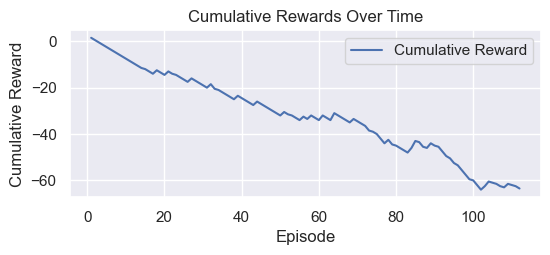

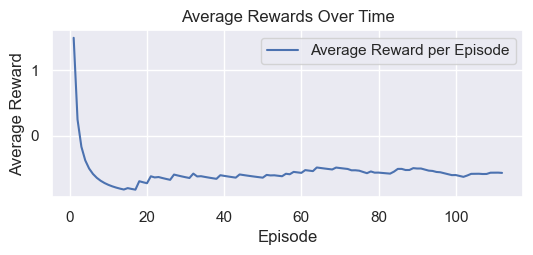

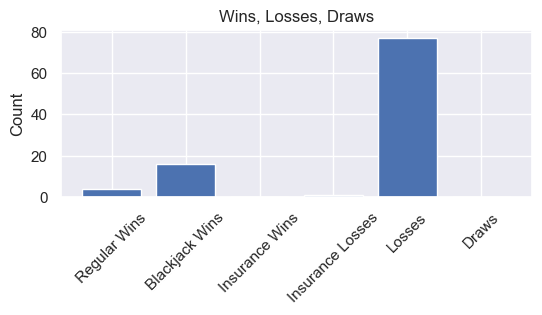

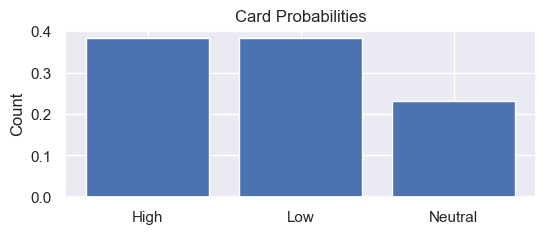

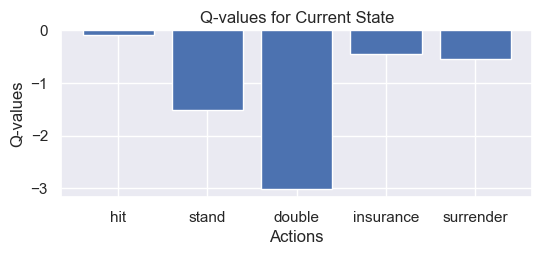

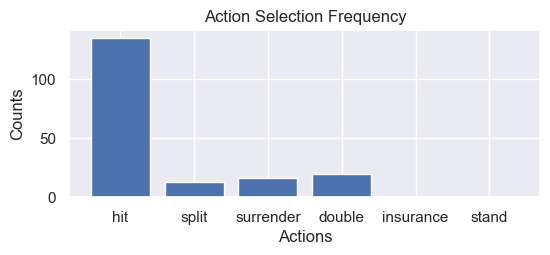

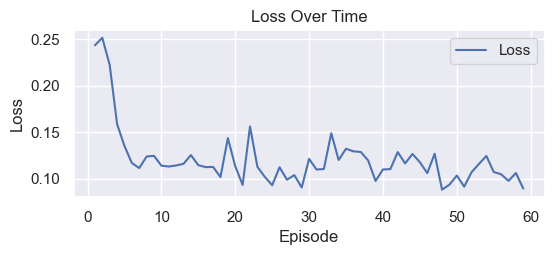

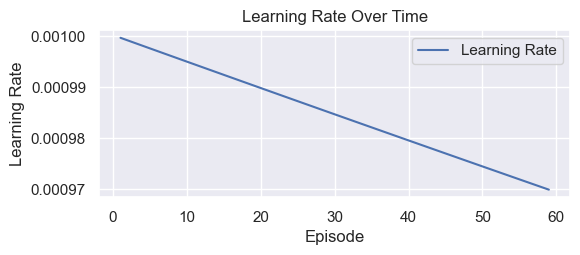

In [15]:
# Create a Deep Q Learning model to learn to play blackjack
# Calculate the state size based on the returned state from get_state method
player_hand_value_size = 1
dealer_visible_card_size = 13  # One-hot encoding of 13 ranks
usable_ace_size = 1
probabilities_size = 3
insurance_possibility_indicator = 1
surrender_possibility_indicator = 1
split_possibility_indicator = 1
state_size = player_hand_value_size + dealer_visible_card_size + usable_ace_size + probabilities_size + insurance_possibility_indicator + surrender_possibility_indicator + split_possibility_indicator

dqn_env = DQNBlackjackEnvironment(model_path=model_path)
dqn_agent = DQNAgent(state_size=state_size, action_space=actions)

# Create and start the GUI
dqn_root = tk.Tk()
dqn_app = DQNBlackjackRL(
    root=dqn_root,
    agent=dqn_agent,
    environment=dqn_env,
    train_episodes=10000,
    test_episodes=1000,
    cnn_model_path=model_path
)

dqn_app.start()